# Evaluating Factors of Rental Listing Quality

Kevin Liu, Rohit Jagga

In this project, we use regression analysis to investigate key variables that may contribute to the quality of an Airbnb listing. We use two dependent variables - overall score and location score - to represent listing quality, and we consider the following kinds of predictors:
1. Intrinsic (i.e. listing-specific) variables: Price, amenities, etc.
2. Sentiment of listing reviews: Polarity and subjectivity
3. Extrinsic variables: Regional crime rate, home value, and hotel value

We analyze three different kinds of regression models:
* "Direct" model: Uses (1) and (2) as predictors. Only uses overall score for dependent variable.
* "External" models: Uses (3) and price as predictors. Uses both dependent variables.
* "Combined" models: Uses (1), (2), and (3) as predictors. Uses both dependent variables.

Our datasets include:
* Airbnb listings data
 * `listings.csv`: New York, 2022
 * `listings_sf.csv`: San Francisco, 2022
 * `listings (X).csv` (where X is a number from 0 to 30): Data from one of 31 cities
* Airbnb reviews data
 * `reviews.csv`: New York, 2022
 * `reviews (X).csv` (where X is a number from 0 to 30): Data from one of 31 cities
* Crime data
 * `crime.csv`: New York, 2022 - present
 * `crime_sf.csv`: San Francisco, 2018 - present
* Population data
 * New York borough population data (2020): Manually added
 * `population_sf.csv`: San Francisco neighborhood population data (2010)
* `home.csv`: Zillow Home Value Index (ZHVI) data, 2000 - present
* `hotel.csv`: Trivago Hotel Price Index (THPI) data, 2022 - present
* All other datasets were created through joining and processing the above datasets.

# Setup

In [2]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import re

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [3]:
%cd './data'

# Load raw data
df_listings = pd.read_csv('listings.csv')
df_listings_sf = pd.read_csv('listings_sf.csv')
df_reviews = pd.read_csv('reviews.csv')
df_crime = pd.read_csv('crime.csv')
df_crime_sf = pd.read_csv('crime_sf.csv')
df_home = pd.read_csv('home.csv')
df_hotel = pd.read_csv('hotel.csv')

total_listings_df = pd.read_csv('listings (0).csv')
total_reviews_df = pd.read_csv('reviews (0).csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Direct model

## Initial verification and processing

First, we prepare data for the direct model. To do this, we randomly sample a subset of data from each of the 31 listings and reviews datasets and then merge them. We chose this random sampling so that our ultimate dataset is not too large for processing within this notebook.

In [4]:
total_listings_df = total_listings_df.sample(frac=0.15, replace=False, random_state=1)
total_reviews_df = total_reviews_df.sample(frac=0.05, replace=False, random_state=1)

In [5]:
total_listings_df.head()

id                                      listing_url  \
1041            31186872            https://www.airbnb.com/rooms/31186872   
2514  551264073523811543  https://www.airbnb.com/rooms/551264073523811543   
1852            47161014            https://www.airbnb.com/rooms/47161014   
825             25132222            https://www.airbnb.com/rooms/25132222   
2665  591230873312834346  https://www.airbnb.com/rooms/591230873312834346   

           scrape_id last_scraped       source  \
1041  20220914194751   2022-09-14  city scrape   
2514  20220914194751   2022-09-14  city scrape   
1852  20220914194751   2022-09-14  city scrape   
825   20220914194751   2022-09-14  city scrape   
2665  20220914194751   2022-09-14  city scrape   

                                                   name  \
1041  Moonrise Motel - Walk to Downtown AVL + River ...   
2514  3 bed 1400 square foot retro arcade and movie ...   
1852                                        The Nauhaus   
825   Light, open home w/ chef's kitchen, screened p...   
2665  Cozy Home Minutes to Downtown, West AVL & Bilt...   

                                            description  \
1041  A T T E N T I O N  /  F I L M  /  L O V E R S:...   
2514  This memorable place is anything but ordinary....   
1852  Beautifully furnished house with a mother-in-l...   
825   Luxurious home in a quiet neighborhood, close ...   
2665  Wonderful Asheville getaway just minutes from ...   

                                  neighborhood_overview  \
1041  West End / Clingman Avenue (WECAN) is a middle...   
2514                                                NaN   
1852  The Nauhaus is located in a medium sized neigh...   
825   Close to grocery store and pharmacy, restauran...   
2665                                                NaN   

                                            picture_url    host_id  ...  \
1041  https://a0.muscache.com/pictures/2b20ff64-2df2...  170251520  ...   
2514  https://a0.muscache.com/pictures/miso/Hosting-...   27754848  ...   
1852  https://a0.muscache.com/pictures/e93bc775-8360...  250586169  ...   
825   https://a0.muscache.com/pictures/9b1a7014-8385...   20537619  ...   
2665  https://a0.muscache.com/pictures/miso/Hosting-...  442004854  ...   

     review_scores_communication review_scores_location review_scores_value  \
1041                        4.99                   4.97                4.97   
2514                        5.00                   5.00                5.00   
1852                        4.80                   4.80                4.80   
825                         4.88                   4.90                4.80   
2665                         NaN                    NaN                 NaN   

     license instant_bookable calculated_host_listings_count  \
1041     NaN                t                              1   
2514     NaN                f                              1   
1852     NaN                t                              1   
825      NaN                t                              1   
2665     NaN                t                              4   

     calculated_host_listings_count_entire_homes  \
1041                                           1   
2514                                           1   
1852                                           1   
825                                            1   
2665                                           4   

     calculated_host_listings_count_private_rooms  \
1041                                            0   
2514                                            0   
1852                                            0   
825                                             0   
2665                                            0   

     calculated_host_listings_count_shared_rooms reviews_per_month  
1041                                           0              4.60  
2514                                           0              3.28  
1852                                       

In [6]:
total_reviews_df.head()

listing_id                  id        date  reviewer_id reviewer_name  \
43369      7665386  414458161930585820  2021-07-25     18911349       Camille   
26996      4129119           186480470  2017-08-24     21867231    Tim+Marisa   
136848    23150406           327336982  2018-09-23    212246390       Melanie   
181861    30509573           520583177  2019-08-30    242584143        Ashley   
321         155305           585351380  2019-12-31     48348849         Grace   

                                                 comments  
43369   Highly recommend! Great location within walkin...  
26996   Wonderful host. Great location.<br/>Sweet , co...  
136848  This is the PERFECT spot if you want a downtow...  
181861  We loved staying here. It was beautiful, comfo...  
321     We stayed in the cabin for a weekend and it wa...

In [7]:
# Randomly sample from each city's listings/reviews datasets and append to respective dfs
for i in range(1, 31):
  listings_df = pd.read_csv(f'listings ({i}).csv')
  reviews_df = pd.read_csv(f'reviews ({i}).csv')

  listings_df = listings_df.sample(frac=0.15, replace=False, random_state=1)
  reviews_df = reviews_df.sample(frac=0.05, replace=False, random_state=1)

  total_listings_df = pd.concat([total_listings_df, listings_df], ignore_index=True)
  total_reviews_df = pd.concat([total_reviews_df, reviews_df], ignore_index=True)


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
print(total_listings_df.shape)
print(total_listings_df.dtypes)

(42005, 75)
id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 75, dtype: object


In [9]:
print(total_reviews_df.shape)
print(total_reviews_df.dtypes)

(562252, 6)
listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object


In [10]:
total_listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [11]:
total_reviews_df.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [12]:
total_listings_df.to_csv('total_listings_df.csv')
total_reviews_df.to_csv('total_reviews_df.csv')

Now that we've created our combined datasets, let's clean them and then merge them.

In [13]:
total_listings_df = total_listings_df.drop(columns=['listing_url', 'scrape_id','last_scraped','source','picture_url','host_thumbnail_url','host_picture_url'])

In [14]:
nan_df = total_listings_df[total_listings_df.isnull().any(axis=1)]

nan_df

id                                               name  \
0                31186872  Moonrise Motel - Walk to Downtown AVL + River ...   
1      551264073523811543  3 bed 1400 square foot retro arcade and movie ...   
2                47161014                                        The Nauhaus   
3                25132222  Light, open home w/ chef's kitchen, screened p...   
4      591230873312834346  Cozy Home Minutes to Downtown, West AVL & Bilt...   
...                   ...                                                ...   
42000            18281120                      Cozy guest house w/ roof deck   
42001            24264845                    Private bedroom on Capitol Hill   
42002            15618501  Ahhhh Relaxing!!!(& Most Comfortable Bed EVER!!!)   
42003            25418257    Comfortable CityView Apartment, queen bed+couch   
42004            16376614        Large one bedroom apartment in Mt. Pleasant   

                                             description  \
0      A T T E N T I O N  /  F I L M  /  L O V E R S:...   
1      This memorable place is anything but ordinary....   
2      Beautifully furnished house with a mother-in-l...   
3      Luxurious home in a quiet neighborhood, close ...   
4      Wonderful Asheville getaway just minutes from ...   
...                                                  ...   
42000  Cozy, clean studio in the popular Columbia Hei...   
42001  4 min walk to hipster H St NE with plenty of b...   
42002  My place is great 4 couples, solo adventurers,...   
42003  1. less than a one-minute walk from Foggy Bott...   
42004  A spacious one bedroom basement apartment in M...   

                                   neighborhood_overview    host_id  \
0      West End / Clingman Avenue (WECAN) is a middle...  170251520   
1                                                    NaN   27754848   
2      The Nauhaus is located in a medium sized neigh...  250586169   
3      Close to grocery store and pharmacy, restauran...   20537619   
4                                                    NaN  442004854   
...                                                  ...        ...   
42000  Located in the popular Columbia Heights neighb...     690881   
42001                                                NaN  104377990   
42002  1.5 miles from Md, Catholic & Gallaudet Univ, ...   67905334   
42003                                                NaN   97432247   
42004  Mount Pleasant is convenient to everything DC ...   31214578   

                                          host_url  host_name  host_since  \
0      https://www.airbnb.com/users/show/170251520        Mel  2018-01-27   
1       https://www.airbnb.com/users/show/27754848    Gabriel  2015-02-14   
2      https://www.airbnb.com/users/show/250586169    Jackson  2019-03-22   
3       https://www.airbnb.com/users/show/20537619       Jane  2014-08-25   
4      https://www.airbnb.com/users/show/442004854       Buna  2022-01-25   
...                                            ...        ...         ...   
42000     https://www.airbnb.com/users/show/690881  Stephanie  2011-06-11   
42001  https://www.airbnb.com/users/show/104377990    Melissa  2016-11-19   
42002   https://www.airbnb.com/users/show/67905334   Deatrice  2016-04-19   
42003   https://www.airbnb.com/users/show/97432247        Xun  2016-09-30   
42004   https://www.airbnb.com/users/show/31214578      Ledio  2015-04-14   

                host_location  \
0               Asheville, NC   
1               Asheville, NC   
2             Weaverville, NC   
3                  Arvada, CO   
4               Asheville, NC   
...                       ...   
42000          Washington, DC   
42001  London, United Kingdom   
42002          Washington, DC   
42003          Washington, DC   
42004          Washington, DC   

                                              host_about  ...  \
0      Mel works from home, which allows her to be ul...  ...   
1      I am a medical engineer and a

In [15]:
# Drop null rows
total_listings_df = total_listings_df[~np.isnan(total_listings_df['review_scores_rating'])]
total_reviews_df = total_reviews_df[~np.isnan(total_reviews_df['listing_id'])]

In [16]:
# Merge listings and reviews data
merged_df = total_listings_df.merge(total_reviews_df, left_on='id', right_on='listing_id', how='inner')

merged_df

id_x                                               name  \
0                31186872  Moonrise Motel - Walk to Downtown AVL + River ...   
1                31186872  Moonrise Motel - Walk to Downtown AVL + River ...   
2                31186872  Moonrise Motel - Walk to Downtown AVL + River ...   
3                31186872  Moonrise Motel - Walk to Downtown AVL + River ...   
4      551264073523811543  3 bed 1400 square foot retro arcade and movie ...   
...                   ...                                                ...   
89736            18281120                      Cozy guest house w/ roof deck   
89737            18281120                      Cozy guest house w/ roof deck   
89738            18281120                      Cozy guest house w/ roof deck   
89739            18281120                      Cozy guest house w/ roof deck   
89740            16376614        Large one bedroom apartment in Mt. Pleasant   

                                             description  \
0      A T T E N T I O N  /  F I L M  /  L O V E R S:...   
1      A T T E N T I O N  /  F I L M  /  L O V E R S:...   
2      A T T E N T I O N  /  F I L M  /  L O V E R S:...   
3      A T T E N T I O N  /  F I L M  /  L O V E R S:...   
4      This memorable place is anything but ordinary....   
...                                                  ...   
89736  Cozy, clean studio in the popular Columbia Hei...   
89737  Cozy, clean studio in the popular Columbia Hei...   
89738  Cozy, clean studio in the popular Columbia Hei...   
89739  Cozy, clean studio in the popular Columbia Hei...   
89740  A spacious one bedroom basement apartment in M...   

                                   neighborhood_overview    host_id  \
0      West End / Clingman Avenue (WECAN) is a middle...  170251520   
1      West End / Clingman Avenue (WECAN) is a middle...  170251520   
2      West End / Clingman Avenue (WECAN) is a middle...  170251520   
3      West End / Clingman Avenue (WECAN) is a middle...  170251520   
4                                                    NaN   27754848   
...                                                  ...        ...   
89736  Located in the popular Columbia Heights neighb...     690881   
89737  Located in the popular Columbia Heights neighb...     690881   
89738  Located in the popular Columbia Heights neighb...     690881   
89739  Located in the popular Columbia Heights neighb...     690881   
89740  Mount Pleasant is convenient to everything DC ...   31214578   

                                          host_url  host_name  host_since  \
0      https://www.airbnb.com/users/show/170251520        Mel  2018-01-27   
1      https://www.airbnb.com/users/show/170251520        Mel  2018-01-27   
2      https://www.airbnb.com/users/show/170251520        Mel  2018-01-27   
3      https://www.airbnb.com/users/show/170251520        Mel  2018-01-27   
4       https://www.airbnb.com/users/show/27754848    Gabriel  2015-02-14   
...                                            ...        ...         ...   
89736     https://www.airbnb.com/users/show/690881  Stephanie  2011-06-11   
89737     https://www.airbnb.com/users/show/690881  Stephanie  2011-06-11   
89738     https://www.airbnb.com/users/show/690881  Stephanie  2011-06-11   
89739     https://www.airbnb.com/users/show/690881  Stephanie  2011-06-11   
89740   https://www.airbnb.com/users/show/31214578      Ledio  2015-04-14   

        host_location                                         host_about  ...  \
0       Asheville, NC  Mel works from home, which allows her to be ul...  ...   
1       Asheville, NC  Mel works from home, which allows her to be ul...  ...   
2       Asheville, NC  Mel works from home, which allows her to be ul...  ...   
3       Asheville, NC  Mel works from home, which allows her to be ul...  ...   
4       Asheville, NC  I am a medical engineer and artist. I speciali...  ...   
...               ...                                                ...  .

## Sentiment analysis

Now, we use the NLTK package for sentiment analysis of listing reviews. Specifically, we obtain the polarity and subjectivity of each review of a listing.

### Sentiment analysis test

First, let's perform a sample test to see if the polarity and subjectivity outputs make sense.

In [17]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [18]:
sample_review_1 = '''
This is the PERFECT spot if you want a downtown Asheville location.  
It is close enough to walk to everything. The neighborhood is so cute and quiet. 
Micah has the yummiest linens and the most comfortable beddings for a great night's rest. We had a GREAT stay!
'''

In [19]:
sample_review_2 = '''
Horrible experience. Good luck dealing with these money hungry people. 
No customer service. No accommodations. Horrible experience.
'''

In [20]:
print(f"Sample string 1's polarity score: {getPolarity(sample_review_1)}")
print(f"Sample string 1's subjectivity score: {getSubjectivity(sample_review_1)}")

print(f"Sample string 2's polarity score: {getPolarity(sample_review_2)}")
print(f"Sample string 2's subjectivity score: {getSubjectivity(sample_review_2)}")

Sample string 1's polarity score: 0.525
Sample string 1's subjectivity score: 0.7041666666666667
Sample string 2's polarity score: -0.43333333333333335
Sample string 2's subjectivity score: 0.8666666666666667


### Sentiment analysis on data

Now, we compute the polarity and subjectivity of (1) the comments (reviews), (2) the listing descriptions, and (3) the neighborhood descriptions. We eventually focus on (1), as it is the most significant predictor.

In [21]:
# sentiment analysis for review comments
merged_df['comment_polarity'] = merged_df.apply(lambda x: getPolarity(str(x['comments'])), axis=1)
merged_df['comment_subjectivity'] = merged_df.apply(lambda x: getSubjectivity(str(x['comments'])), axis=1)

# sentiment analysis for listing's description & neighborhood columns
merged_df['description_polarity'] = merged_df.apply(lambda x: getPolarity(str(x['description'])), axis=1)
merged_df['description_subjectivity'] = merged_df.apply(lambda x: getSubjectivity(str(x['description'])), axis=1)

In [22]:
merged_df.to_csv("merged_df.csv")

In [23]:
merged_df = pd.read_csv("merged_df.csv")
merged_df = merged_df.iloc[:,1:]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
merged_df['neighborhood_polarity'] = merged_df.apply(lambda x: getPolarity(str(x['neighborhood_overview'])), axis=1)
merged_df['neighborhood_subjectivity'] = merged_df.apply(lambda x: getSubjectivity(str(x['neighborhood_overview'])), axis=1)

In [25]:
merged_df.columns

Index(['id_x', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_3

In [26]:
included_cols = ['host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 

       'latitude','longitude', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 
       'price',

       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 
       
       'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 
       
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 

       'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',

       'listing_id', 'id_y', 'date',
       
       'sentiment_polarity', 'sentiment_subjectivity',
       'comment_polarity', 'comment_subjectivity', 'description_polarity',
       'description_subjectivity', 'neighborhood_polarity',
       'neighborhood_subjectivity'
]

In [27]:
merged_df.head()

id_x                                               name  \
0  3.118687e+07  Moonrise Motel - Walk to Downtown AVL + River ...   
1  3.118687e+07  Moonrise Motel - Walk to Downtown AVL + River ...   
2  3.118687e+07  Moonrise Motel - Walk to Downtown AVL + River ...   
3  3.118687e+07  Moonrise Motel - Walk to Downtown AVL + River ...   
4  5.512641e+17  3 bed 1400 square foot retro arcade and movie ...   

                                         description  \
0  A T T E N T I O N  /  F I L M  /  L O V E R S:...   
1  A T T E N T I O N  /  F I L M  /  L O V E R S:...   
2  A T T E N T I O N  /  F I L M  /  L O V E R S:...   
3  A T T E N T I O N  /  F I L M  /  L O V E R S:...   
4  This memorable place is anything but ordinary....   

                               neighborhood_overview      host_id  \
0  West End / Clingman Avenue (WECAN) is a middle...  170251520.0   
1  West End / Clingman Avenue (WECAN) is a middle...  170251520.0   
2  West End / Clingman Avenue (WECAN) is a middle...  170251520.0   
3  West End / Clingman Avenue (WECAN) is a middle...  170251520.0   
4                                                NaN   27754848.0   

                                      host_url host_name  host_since  \
0  https://www.airbnb.com/users/show/170251520       Mel  2018-01-27   
1  https://www.airbnb.com/users/show/170251520       Mel  2018-01-27   
2  https://www.airbnb.com/users/show/170251520       Mel  2018-01-27   
3  https://www.airbnb.com/users/show/170251520       Mel  2018-01-27   
4   https://www.airbnb.com/users/show/27754848   Gabriel  2015-02-14   

   host_location                                         host_about  ...  \
0  Asheville, NC  Mel works from home, which allows her to be ul...  ...   
1  Asheville, NC  Mel works from home, which allows her to be ul...  ...   
2  Asheville, NC  Mel works from home, which allows her to be ul...  ...   
3  Asheville, NC  Mel works from home, which allows her to be ul...  ...   
4  Asheville, NC  I am a medical engineer and artist. I speciali...  ...   

         date  reviewer_id reviewer_name  \
0  2020-01-26    1755226.0        Lauren   
1  2021-07-04   40805117.0          Kyli   
2  2021-11-21  404566039.0         Kelly   
3  2020-12-07  126308225.0       Natalia   
4  2022-07-04   24380278.0        Daniel   

                                            comments comment_polarity  \
0  About 20 min walk downtown to breweries- withi...         0.425000   
1  The Moonrise Motel was everything we wanted an...         0.434722   
2  A must stay! The place is so wonderfully decor...         0.497125   
3  Perfect stay in Asheville. In close proximity ...         0.165000   
4  This Airbnb was an absolute dream! We booked w...         0.216944   

   comment_subjectivity  description_polarity description_subjectivity  \
0              0.791667              0.208081                 0.499471   
1              0.683333              0.208081                 0.499471   
2              0.740000              0.208081                 0.499471   
3              0.890000              0.208081                 0.499471   
4              0.502222              0.231994                 0.587351   

  neighborhood_polarity neighborhood_subjectivity  
0              0.209091                      0.35  
1              0.209091                      0.35  
2              0.209091                      0.35  
3              0.209091                      0.35  
4              0.000000                      0.00  

[5 rows x 80 columns]

In [28]:
sentiment_reviews_df = merged_df[['listing_id',
       'comment_polarity', 'comment_subjectivity', 'description_polarity',
       'description_subjectivity', 'neighborhood_polarity',
       'neighborhood_subjectivity']].groupby(['listing_id']).mean()

sentiment_reviews_df

comment_polarity  comment_subjectivity  description_polarity  \
listing_id                                                                   
5.920000e+02          0.341129              0.630226              0.267130   
1.940000e+03          0.435979              0.696668              0.225905   
4.534000e+03          0.389965              0.613116              0.327381   
6.413000e+03          0.394329              0.559433              0.263778   
7.801000e+03          0.361111              0.477778              0.235128   
...                        ...                   ...                   ...   
7.067147e+17          0.291667              0.487500              0.234750   
7.072856e+17          0.825000              0.875000              0.266667   
7.081672e+17          0.000000              0.000000              0.254545   
7.100065e+17          0.216429              0.598214              0.204539   
7.101867e+17          0.558333              0.475000              0.335000   

              description_subjectivity  neighborhood_polarity  \
listing_id                                                      
5.920000e+02                  0.506481               0.000000   
1.940000e+03                  0.514625               0.124306   
4.534000e+03                  0.493155               0.228929   
6.413000e+03                  0.434317               0.341667   
7.801000e+03                  0.399184               0.333333   
...                                ...                    ...   
7.067147e+17                  0.488543               0.000000   
7.072856e+17                  0.583333               0.068182   
7.081672e+17                  0.684943               0.000000   
7.100065e+17                  0.485640               0.194167   
7.101867e+17                  0.578333               0.411111   

              neighborhood_subjectivity  
listing_id                               
5.920000e+02                   0.000000  
1.940000e+03                   0.511111  
4.534000e+03                   0.416190  
6.413000e+03                   0.916667  
7.801000e+03                   0.626667  
...                                 ...  
7.067147e+17                   0.000000  
7.072856e+17                   0.227273  
7.081672e+17                   0.000000  
7.100065e+17                   0.376667  
7.101867e+17                   0.527778  

[19557 rows x 6 columns]

In [29]:
merged_df2 = pd.merge(merged_df[['id_x','host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 

       'latitude','longitude', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 
       'price',

       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 
       
       'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 
       
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 

       'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']], sentiment_reviews_df, how='inner', left_on='id_x', right_on='listing_id')

merged_df2

id_x  host_since   host_location host_response_time  \
0      3.118687e+07  2018-01-27   Asheville, NC     within an hour   
1      3.118687e+07  2018-01-27   Asheville, NC     within an hour   
2      3.118687e+07  2018-01-27   Asheville, NC     within an hour   
3      3.118687e+07  2018-01-27   Asheville, NC     within an hour   
4      5.512641e+17  2015-02-14   Asheville, NC     within an hour   
...             ...         ...             ...                ...   
88981  1.828112e+07  2011-06-11  Washington, DC     within an hour   
88982  1.828112e+07  2011-06-11  Washington, DC     within an hour   
88983  1.828112e+07  2011-06-11  Washington, DC     within an hour   
88984  1.828112e+07  2011-06-11  Washington, DC     within an hour   
88985  1.637661e+07  2015-04-14  Washington, DC       within a day   

      host_response_rate host_acceptance_rate host_is_superhost  \
0                   100%                 100%                 t   
1                   100%                 100%                 t   
2                   100%                 100%                 t   
3                   100%                 100%                 t   
4                   100%                  96%                 f   
...                  ...                  ...               ...   
88981               100%                 100%                 t   
88982               100%                 100%                 t   
88983               100%                 100%                 t   
88984               100%                 100%                 t   
88985               100%                 100%                 f   

       host_listings_count  host_total_listings_count  host_verifications  \
0                      1.0                        1.0  ['email', 'phone']   
1                      1.0                        1.0  ['email', 'phone']   
2                      1.0                        1.0  ['email', 'phone']   
3                      1.0                        1.0  ['email', 'phone']   
4                      1.0                        2.0  ['email', 'phone']   
...                    ...                        ...                 ...   
88981                  1.0                        3.0  ['email', 'phone']   
88982                  1.0                        3.0  ['email', 'phone']   
88983                  1.0                        3.0  ['email', 'phone']   
88984                  1.0                        3.0  ['email', 'phone']   
88985                  1.0                        3.0  ['email', 'phone']   

       ... calculated_host_listings_count_entire_homes  \
0      ...                                         1.0   
1      ...                                         1.0   
2      ...                                         1.0   
3      ...                                         1.0   
4      ...                                         1.0   
...    ...                                         ...   
88981  ...                                         1.0   
88982  ...                                         1.0   
88983  ...                                         1.0   
88984  ...                                         1.0   
88985  ...                                         1.0   

      calculated_host_listings_count_private_rooms  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   
...                                            ...   
88981                                          0.0   
88982                                          0.0   
88983                                          0.0   
88984                                          0.0   
88985                                          0.0   

       calculated_host_listings_count_shared_rooms  reviews_per_month  \
0                        

We have now merged all the sentiment analysis results with our listings and reviews data, so we now re-format some of the columns in the merged dataset to prepare for EDA and regression analysis.

In [30]:
# Change formatting of columns
merged_df2 = merged_df2.rename({'id_x': 'listing_id'}, axis=1)
merged_df2['amenities'] = merged_df2['amenities'].apply(len)
merged_df2['amenities'] = merged_df2['amenities'].astype(float)
merged_df2['price'] = merged_df2['price'].apply(lambda s: re.sub('[$,]', '', s)).astype(float)

merged_df2['host_response_rate'] = merged_df2['host_response_rate'].apply(lambda s: re.sub('%', '', str(s))).astype(float)
merged_df2['host_response_rate'] = merged_df2['host_response_rate'].apply(lambda x: (x+0.0001) / 100)
merged_df2['host_acceptance_rate'] = merged_df2['host_acceptance_rate'].apply(lambda s: re.sub('%', '', str(s))).astype(float)
merged_df2['host_acceptance_rate'] = merged_df2['host_acceptance_rate'].apply(lambda x: (x+0.0001) / 100)

merged_df2['host_is_superhost'] = merged_df2['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0).astype(float)
merged_df2['host_listings_count'] = merged_df2['host_listings_count'].apply(lambda x: x).astype(float)
merged_df2['host_total_listings_count'] = merged_df2['host_total_listings_count'].apply(lambda x: x).astype(float)

merged_df2['host_has_profile_pic'] = merged_df2['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0).astype(float)
merged_df2['host_identity_verified'] = merged_df2['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0).astype(float)

merged_df2['accommodates'] = merged_df2['accommodates'].apply(lambda x: x).astype(float)
merged_df2['bathrooms_text'] = merged_df2['bathrooms_text'].apply(lambda x: str(x).split()[0])

def bathrooms_text_to_float(x):
  try:
    return float(x)
  except:
    return 0
merged_df2['bathrooms_text'] = merged_df2['bathrooms_text'].apply(lambda x: bathrooms_text_to_float(x))

merged_df2['minimum_nights'] = merged_df2['minimum_nights'].apply(lambda x: x).astype(float)
merged_df2['maximum_nights'] = merged_df2['maximum_nights'].apply(lambda x: x).astype(float)

merged_df2['number_of_reviews'] = merged_df2['number_of_reviews'].apply(lambda x: x).astype(float)

merged_df2['instant_bookable'] = merged_df2['instant_bookable'].apply(lambda x: 1 if x == 't' else 0).astype(float)

merged_df2 = merged_df2.drop(['bedrooms','host_verifications','calendar_last_scraped', 'host_since','first_review','last_review'], axis=1)

In [31]:
for row in merged_df2:
  print(f"{row}: {merged_df2[row].dtype}")

listing_id: float64
host_location: object
host_response_time: object
host_response_rate: float64
host_acceptance_rate: float64
host_is_superhost: float64
host_listings_count: float64
host_total_listings_count: float64
host_has_profile_pic: float64
host_identity_verified: float64
latitude: float64
longitude: float64
room_type: object
accommodates: float64
bathrooms_text: float64
beds: float64
amenities: float64
price: float64
minimum_nights: float64
maximum_nights: float64
minimum_minimum_nights: float64
maximum_minimum_nights: float64
minimum_maximum_nights: float64
maximum_maximum_nights: float64
minimum_nights_avg_ntm: float64
maximum_nights_avg_ntm: float64
has_availability: object
availability_30: float64
availability_60: float64
availability_90: float64
availability_365: float64
number_of_reviews: float64
number_of_reviews_ltm: float64
number_of_reviews_l30d: float64
review_scores_rating: float64
review_scores_accuracy: float64
review_scores_cleanliness: float64
review_scores_chec

In [32]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
  display(merged_df2)

listing_id   host_location host_response_time  host_response_rate  \
0      31186872.0   Asheville, NC     within an hour            1.000001   
1      31186872.0   Asheville, NC     within an hour            1.000001   
...           ...             ...                ...                 ...   
88984  18281120.0  Washington, DC     within an hour            1.000001   
88985  16376614.0  Washington, DC       within a day            1.000001   

       host_acceptance_rate  host_is_superhost  host_listings_count  \
0                  1.000001                1.0                  1.0   
1                  1.000001                1.0                  1.0   
...                     ...                ...                  ...   
88984              1.000001                1.0                  1.0   
88985              1.000001                0.0                  1.0   

       host_total_listings_count  host_has_profile_pic  \
0                            1.0                   1.0   
1                            1.0                   1.0   
...                          ...                   ...   
88984                        3.0                   1.0   
88985                        3.0                   1.0   

       host_identity_verified  latitude  longitude        room_type  \
0                         1.0  35.59066  -82.56795  Entire home/apt   
1                         1.0  35.59066  -82.56795  Entire home/apt   
...                       ...       ...        ...              ...   
88984                     1.0  38.92239  -77.02789  Entire home/apt   
88985                     0.0  38.93436  -77.04308  Entire home/apt   

       accommodates  bathrooms_text  beds  amenities  price  minimum_nights  \
0               2.0             1.0   1.0      718.0  121.0             2.0   
1               2.0             1.0   1.0      718.0  121.0             2.0   
...             ...             ...   ...        ...    ...             ...   
88984           2.0             1.0   1.0      750.0  119.0             3.0   
88985           2.0             1.0   1.0      342.0  130.0            31.0   

       maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0                30.0                     2.0                     3.0   
1                30.0                     2.0                     3.0   
...               ...                     ...                     ...   
88984          1125.0                     3.0                     3.0   
88985          1125.0                    31.0                    31.0   

       minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                      1125.0                  1125.0                     2.6   
1                      1125.0                  1125.0                     2.6   
...                       ...                     ...                     ...   
88984                  1125.0                  1125.0                     3.0   
88985                  1125.0                  1125.0                    31.0   

       maximum_nights_avg_ntm has_availability  availability_30  \
0                      1125.0                t              7.0   
1                      1125.0                t              7.0   
...                       ...              ...              ...   
88984                  1125.0                t             15.0   
88985                  1125.0                t             30.0   

       availability_60  availability_90  availability_365  number_of_reviews  \
0                 11.0             35.0             113.0              184.0   
1                 11.0             35.0             113.0              184.0   
...                ...              ...               ...                ...   
88984             30.0             60.0             149.0              136.0   
88985             60.0             90.0             364.0               10.0   

       number_of_reviews_ltm  number_of_reviews_l30d  review_s

In [33]:
merged_df2.columns

Index(['listing_id', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
      

### EDA (sentiment analysis results)

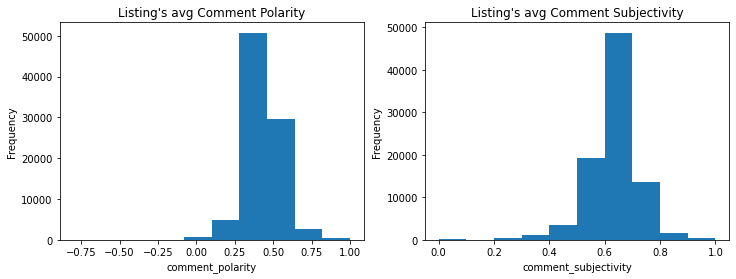

In [34]:
fig, axs = plt.subplots(ncols=2)

axs[0].hist(merged_df2['comment_polarity'])
axs[0].set_xlabel('comment_polarity')
axs[0].set_ylabel('Frequency')
axs[0].set_title("Listing's avg Comment Polarity")

axs[1].hist(merged_df2['comment_subjectivity'])
axs[1].set_xlabel('comment_subjectivity')
axs[1].set_ylabel('Frequency')
axs[1].set_title("Listing's avg Comment Subjectivity")

fig.set_size_inches(12, 4)
plt.show()

It looks like the average comment polarity and subjectivity are both above zero. That is, reviews tend to be positive and subjective.

## Regression

### EDA (visualizations)

We can also plot regression plots to get a sense of how correlated the comment polarity and subjectivity are with the overall score (`review_scores_rating`).

In [35]:
cleaned_df = merged_df2

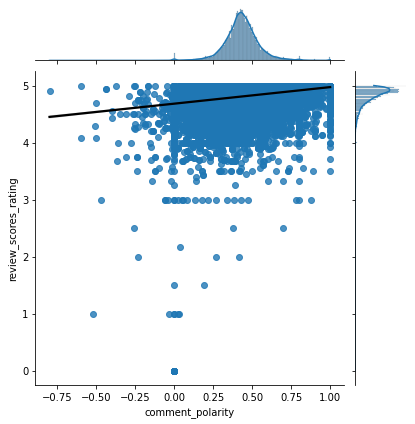

In [36]:
sns.jointplot(x=cleaned_df['comment_polarity'], y=cleaned_df['review_scores_rating'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.show()

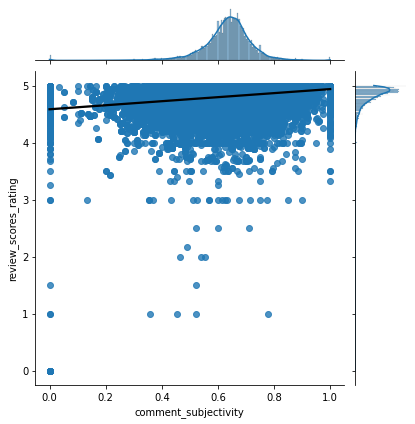

In [37]:
sns.jointplot(x=cleaned_df['comment_subjectivity'], y=cleaned_df['review_scores_rating'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.show()

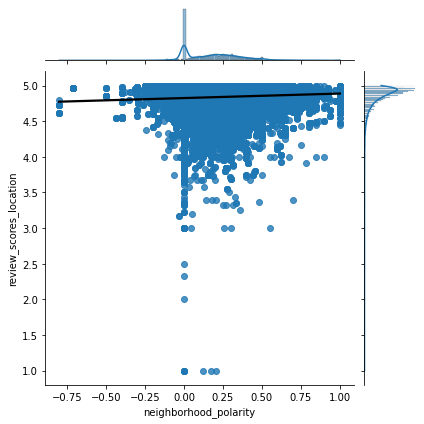

In [38]:
sns.jointplot(x=cleaned_df['neighborhood_polarity'], y=cleaned_df['review_scores_location'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.show()

### Model

Finally, let's create a regression model to see which predictors are significant.

In [39]:
cleaned_df.columns

Index(['listing_id', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
      

In [40]:
model = ols('''review_scores_rating ~ 
  host_response_time + host_response_rate + host_identity_verified + host_total_listings_count +
  price + C(room_type) + amenities + accommodates + availability_365 + instant_bookable + 
  calculated_host_listings_count + number_of_reviews +
  comment_polarity + neighborhood_polarity + 
  comment_subjectivity''', 
  data=cleaned_df)

fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.171
Model:                              OLS   Adj. R-squared:                  0.171
Method:                   Least Squares   F-statistic:                     890.5
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                          04:26:51   Log-Likelihood:                 31859.
No. Observations:                 82049   AIC:                        -6.368e+04
Df Residuals:                     82029   BIC:                        -6.349e+04
Df Model:                            19                                         
Covariance Type:              nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    4.4988      0.010    458.446      0.000       4.480       4.518
host_response_time[T.within a day]          -0.1916      0.012    -15.559      0.000      -0.216      -0.167
host_response_time[T.within a few hours]    -0.2148      0.013    -16.781      0.000      -0.240      -0.190
host_response_time[T.within an hour]        -0.2160      0.013    -16.773      0.000      -0.241      -0.191
C(room_type)[T.Hotel room]                  -0.2357      0.006    -36.957      0.000      -0.248      -0.223
C(room_type)[T.Private room]                -0.0297      0.002    -19.212      0.000      -0.033      -0.027
C(room_type)[T.Shared room]                 -0.1621      0.009    -17.361      0.000      -0.180      -0.144
host_response_rate                           0.3589      0.012     31.074      0.000       0.336       0.382
host_identity_verified                      -0.0117      0.002     -6.943      0.000      -0.015      -0.008
host_total_listings_count                   -0.0001   5.57e-06    -20.682      0.000      -0.000      -0.000
price                                     2.996e-05   1.92e-06     15.618      0.000    2.62e-05    3.37e-05
amenities                                    0.0001   2.33e-06     53.184      0.000       0.000       0.000
accommodates                                -0.0065      0.000    -25.411      0.000      -0.007      -0.006
availability_365                            -0.0002   5.06e-06    -29.683      0.000      -0.000      -0.000
instant_bookable                            -0.0276      0.001    -22.535      0.000      -0.030      -0.025
calculated_host_listings_count              -0.0007   2.48e-05    -26.935      0.000      -0.001      -0.001
number_of_reviews                         5.441e-05   2.95e-06     18.452      0.000    4.86e-05    6.02e-05
comment_polarity                             0.1960      0.007     27.746      0.000       0.182       0.210
neighborhood_polarity                        0.0229      0.003      7.596      0.000       0.017       0.029
comment_subjectivity                         0.1271      0.009     14.826      0.000       0.110       0.144
==============================================================================
Omnibus:                    63632.710   Durbin-Watson:                   0.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6382417.977
Skew:                          -3.063   Prob(JB):                         0.00
Kurtosis:                      45.771   Cond. No.                     3.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is c

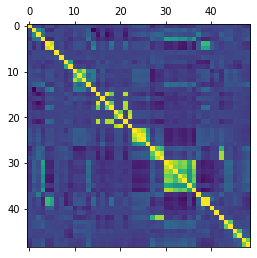

In [41]:
plt.matshow(cleaned_df.corr())
plt.show()

We see that most predictors are significant, especially ones like price and comment polarity.

# External model

Now, let's extract some extrinsic variables from our external datasets and incorporate those into regression analysis.

## Initial verification and processing

In [42]:
for df in [df_listings, df_listings_sf, df_reviews, df_crime, df_crime_sf, df_home, df_hotel]:
  print(df.shape)
  print(df.columns)
  print('_' * 70)

(39881, 75)
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_a

In [43]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

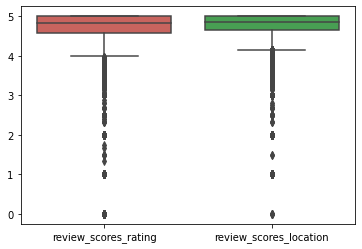

In [44]:
# Plot distribution of dependent variables (New York)
sns.boxplot(
    data=df_listings[['review_scores_rating', 'review_scores_location']],
    palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"]]
)
plt.show()

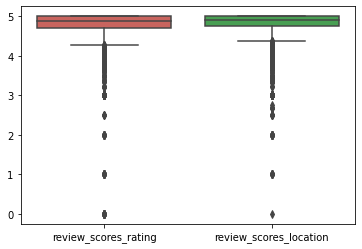

In [45]:
# Plot distribution of dependent variables (San Francisco)
sns.boxplot(
    data=df_listings_sf[['review_scores_rating', 'review_scores_location']],
    palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"]]
)
plt.show()

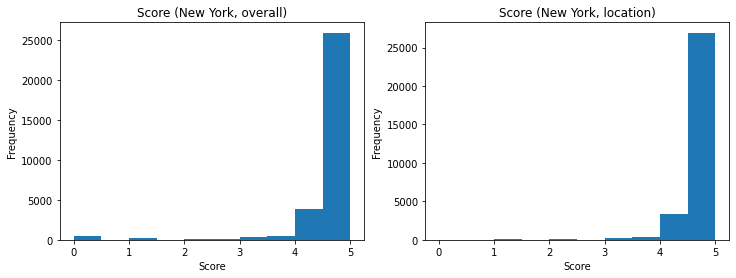

In [46]:
fig, axs = plt.subplots(ncols=2)

axs[0].hist(df_listings['review_scores_rating'])
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Score (New York, overall)')

axs[1].hist(df_listings['review_scores_location'])
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Score (New York, location)')

fig.set_size_inches(12, 4)
plt.show()

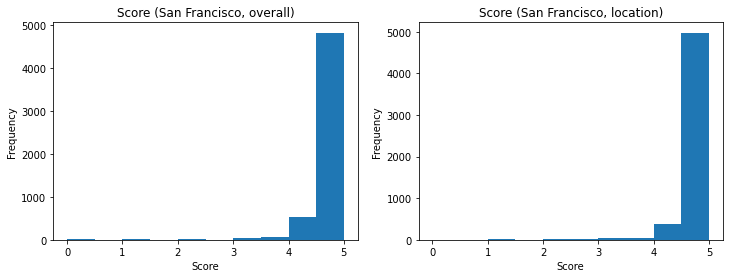

In [47]:
fig, axs = plt.subplots(ncols=2)

axs[0].hist(df_listings_sf['review_scores_rating'])
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Score (San Francisco, overall)')

axs[1].hist(df_listings_sf['review_scores_location'])
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Score (San Francisco, location)')

fig.set_size_inches(12, 4)
plt.show()

In [48]:
reviews = ['number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']
df_listings[reviews].head()

number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
0                  9                      0                       0   
1                 49                      1                       0   
2                 50                      0                       0   
3                 13                      0                       0   
4                  3                      1                       1   

  first_review last_review  review_scores_rating  review_scores_accuracy  \
0   2015-12-04  2018-10-19                  4.89                    4.88   
1   2009-11-21  2022-06-21                  4.68                    4.73   
2   2009-05-28  2019-12-02                  4.52                    4.22   
3   2012-01-03  2019-11-12                  4.42                    4.64   
4   2014-01-02  2022-08-10                  5.00                    5.00   

   review_scores_cleanliness  review_scores_checkin  \
0                       5.00                   5.00   
1                       4.63                   4.77   
2                       4.09                   4.91   
3                       4.36                   4.82   
4                       5.00                   5.00   

   review_scores_communication  review_scores_location  review_scores_value  
0                         5.00                    4.75                 4.88  
1                         4.80                    4.81                 4.40  
2                         4.91                    4.47                 4.52  
3                         5.00                    4.82                 4.55  
4                         5.00                    4.67                 5.00

## New York model

First, we look at external data for New York City - specifically, its crime rate, home value, and hotel value.

### Ratings vs. crime rate

In this section, we take data about crime complaints in New York and use it to extract 2022 crime rate data for each borough.

In [49]:
pd.isnull(df_listings['review_scores_rating']).sum()

8362

In [50]:
df_listings = df_listings.dropna(subset=['review_scores_rating'])

In [51]:
pd.isnull(df_crime['CMPLNT_FR_TM']).sum()

0

In [52]:
# Limit only to rows in 2022
cutoff = pd.to_datetime('01/01/2022')
df_listings['date'] = pd.to_datetime(df_listings['last_review'])
df_listings_filtered = df_listings[df_listings['date'] >= cutoff].copy()

In [53]:
df_crime = df_crime[df_crime['BORO_NM'] != '(null)'].copy()
df_crime['date'] = pd.to_datetime(df_crime['CMPLNT_FR_DT'], errors='coerce')
df_crime['month'] = df_crime['date'].dt.to_period('M').dt.to_timestamp()
df_crime

CMPLNT_NUM  ADDR_PCT_CD        BORO_NM CMPLNT_FR_DT CMPLNT_FR_TM  \
0       247853895         43.0          BRONX   07/11/2022     09:09:00   
1       250722124         67.0       BROOKLYN   01/01/2021     12:00:00   
2       239511545        120.0  STATEN ISLAND   12/24/2021     08:00:00   
3       247992275        115.0         QUEENS   06/15/2015     00:01:00   
4       239602232         75.0       BROOKLYN   01/01/2018     09:00:00   
...           ...          ...            ...          ...          ...   
396973  251818673         46.0          BRONX   09/29/2022     08:30:00   
396974  251891178         94.0       BROOKLYN   09/30/2022     22:55:00   
396975  251788586         79.0       BROOKLYN   09/29/2022     16:15:00   
396976  251833912         70.0       BROOKLYN   09/30/2022     12:00:00   
396977  251833930        107.0         QUEENS   09/30/2022     08:30:00   

       CMPLNT_TO_DT CMPLNT_TO_TM CRM_ATPT_CPTD_CD HADEVELOPT  HOUSING_PSA  \
0               NaN       (null)        COMPLETED     (null)          NaN   
1        09/07/2022     12:00:00        COMPLETED     (null)          NaN   
2        01/03/2022     08:00:00        COMPLETED     (null)          NaN   
3        07/13/2022     17:00:00        COMPLETED     (null)          NaN   
4        04/14/2021     23:59:00        COMPLETED     (null)          NaN   
...             ...          ...              ...        ...          ...   
396973   09/29/2022     08:45:00        COMPLETED     (null)          NaN   
396974   09/30/2022     23:02:00        COMPLETED     (null)          NaN   
396975   09/29/2022     16:18:00        COMPLETED     (null)        510.0   
396976   09/30/2022     12:05:00        COMPLETED     (null)          NaN   
396977   09/30/2022     08:31:00        COMPLETED     (null)          NaN   

        ...                  VIC_RACE VIC_SEX  X_COORD_CD Y_COORD_CD  \
0       ...                   UNKNOWN       D   1022682.0   242998.0   
1       ...                     BLACK       F    997843.0   175671.0   
2       ...  ASIAN / PACIFIC ISLANDER       M    960911.0   165085.0   
3       ...                     WHITE       M   1013677.0   212463.0   
4       ...                     BLACK       M   1022153.0   184000.0   
...     ...                       ...     ...         ...        ...   
396973  ...                   UNKNOWN       F   1011329.0   249447.0   
396974  ...                   UNKNOWN       D    999651.0   199731.0   
396975  ...                   UNKNOWN       E   1000180.0   193720.0   
396976  ...                     BLACK       F    998374.0   171494.0   
396977  ...                   UNKNOWN       E   1032738.0   207968.0   

         Latitude  Longitude                               Lat_Lon  \
0       40.833567 -73.861118               (40.833567, -73.861118)   
1       40.648851 -73.951017  (40.6488507469884, -73.951016510623)   
2       40.619768 -74.084070                (40.619768, -74.08407)   
3       40.749791 -73.893792               (40.749791, -73.893792)   
4       40.671636 -73.863359               (40.671636, -73.863359)   
...           ...        ...                                   ...   
396973  40.851308 -73.902116               (40.851308, -73.902116)   
396974  40.714880 -73.944444                (40.71488, -73.944444)   
396975  40.698381 -73.942550                (40.698381, -73.94255)   
396976  40.637378 -73.949109               (40.637378, -73.949109)   
396977  40.737370 -73.825029                (40.73737, -73.825029)   

                         New Georeferenced Column       date      month  
0                    POINT (-73.861118 40.833567) 2022-07-11 2022-07-01  
1       POINT (-73.951016510623 40.6488507469884) 2021-01-01 2021-01-01  
2                     POINT (-74.08407 40.619768) 2021-12-24 2021-12-01  
3                    POINT (-73.893792 40.749791) 2015-06-15 2015-06-01  
4                    POINT (-73.863359 40.671636) 2018-01-01 2018-01-01  
...                            

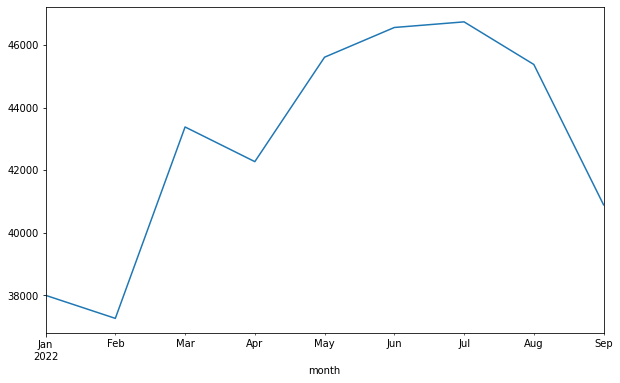

In [54]:
df_crime[df_crime['date'] >= cutoff].groupby('month')['CMPLNT_NUM'].count().plot()
plt.gcf().set_size_inches(10, 6)
plt.show()

In [55]:
df_crime2 = df_crime[df_crime['date'] >= cutoff].copy()

We have now cleaned the New York crime dataset. The next step is to find the number of crime reports in each borough, as well as the population, and use those to compute the crime rate.

In [56]:
df_borough = df_crime2['BORO_NM'].value_counts().reset_index().rename(
    columns={'index': 'borough', 'BORO_NM': 'num_crimes'})
df_borough

borough  num_crimes
0       BROOKLYN      107611
1      MANHATTAN       98181
2         QUEENS       83143
3          BRONX       81186
4  STATEN ISLAND       16031

In [57]:
# From US census (2020)
population = {'BROOKLYN': 2736074, 'MANHATTAN': 1694263, 'QUEENS': 2405464, 'BRONX': 1472654, 'STATEN ISLAND': 495747}
df_borough['population'] = df_borough['borough'].map(population)

# Total number of crimes in 2022 per 100,000 people
df_borough['crime_rate_100k'] = 100000 * df_borough['num_crimes'] / df_borough['population']
df_borough

borough  num_crimes  population  crime_rate_100k
0       BROOKLYN      107611     2736074      3933.044209
1      MANHATTAN       98181     1694263      5794.909055
2         QUEENS       83143     2405464      3456.422545
3          BRONX       81186     1472654      5512.903914
4  STATEN ISLAND       16031      495747      3233.705902

Now, let's join this with the New York listings data and see how crime rate relates to our dependent variables.

In [58]:
rsr_borough = df_listings_filtered.groupby('neighbourhood_group_cleansed')['review_scores_rating'].mean()
rsr_borough.index = rsr_borough.index.map(str.upper)
print(rsr_borough.to_dict())

rsl_borough = df_listings_filtered.groupby('neighbourhood_group_cleansed')['review_scores_location'].mean()
rsl_borough.index = rsl_borough.index.map(str.upper)
print(rsl_borough.to_dict())

{'BRONX': 4.714035433070866, 'BROOKLYN': 4.755742258019719, 'MANHATTAN': 4.692558790593505, 'QUEENS': 4.706220716906576, 'STATEN ISLAND': 4.747507987220447}
{'BRONX': 4.610905511811024, 'BROOKLYN': 4.709023746701847, 'MANHATTAN': 4.804876819708847, 'QUEENS': 4.71425627998871, 'STATEN ISLAND': 4.700575079872205}


In [59]:
df_borough['rating_avg'] = df_borough['borough'].map(rsr_borough.to_dict())
df_borough['location_avg'] = df_borough['borough'].map(rsl_borough.to_dict())
df_borough

borough  num_crimes  population  crime_rate_100k  rating_avg  \
0       BROOKLYN      107611     2736074      3933.044209    4.755742   
1      MANHATTAN       98181     1694263      5794.909055    4.692559   
2         QUEENS       83143     2405464      3456.422545    4.706221   
3          BRONX       81186     1472654      5512.903914    4.714035   
4  STATEN ISLAND       16031      495747      3233.705902    4.747508   

   location_avg  
0      4.709024  
1      4.804877  
2      4.714256  
3      4.610906  
4      4.700575

In [60]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

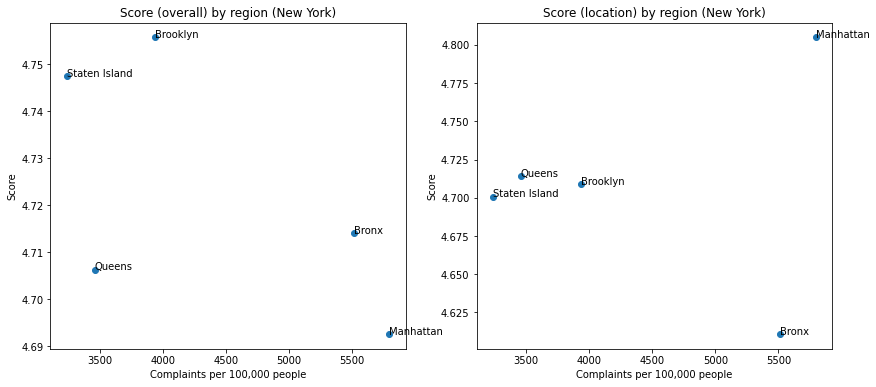

In [61]:
fig, axs = plt.subplots(ncols=2)
labels = df_borough['borough'].str.title()

axs[0].scatter(x=df_borough['crime_rate_100k'], y=df_borough['rating_avg'])
axs[0].set_xlabel('Complaints per 100,000 people')
axs[0].set_ylabel('Score')
axs[0].set_title('Score (overall) by region (New York)')
label_point(df_borough['crime_rate_100k'], df_borough['rating_avg'], labels, axs[0])

axs[1].scatter(x=df_borough['crime_rate_100k'], y=df_borough['location_avg'])
axs[1].set_xlabel('Complaints per 100,000 people')
axs[1].set_ylabel('Score')
axs[1].set_title('Score (location) by region (New York)')
label_point(df_borough['crime_rate_100k'], df_borough['location_avg'], labels, axs[1])

fig.set_size_inches(14, 6)
plt.show()

We expect a negative correlation (i.e. ratings tend to be lower in more dangerous areas). This is somewhat the case for the overall score but not for the location score.

Now, as additional EDA, let's look at crime rate for each borough over time (by month).

In [63]:
df_crime2['month'] = df_crime2['date'].dt.to_period('M').dt.to_timestamp()
df_borough2 = df_crime2.groupby(['BORO_NM', 'month'])['CMPLNT_NUM'].count().reset_index().sort_values(by=['BORO_NM', 'month'])
df_borough2['population'] = df_borough2['BORO_NM'].map(population)
df_borough2['crime_rate_100k'] = 100000 * df_borough2['CMPLNT_NUM'] / df_borough2['population']
df_borough2

BORO_NM      month  CMPLNT_NUM  population  crime_rate_100k
0           BRONX 2022-01-01        8141     1472654       552.811455
1           BRONX 2022-02-01        7798     1472654       529.520172
2           BRONX 2022-03-01        9532     1472654       647.266771
3           BRONX 2022-04-01        8941     1472654       607.135145
4           BRONX 2022-05-01        9623     1472654       653.446091
5           BRONX 2022-06-01        9757     1472654       662.545309
6           BRONX 2022-07-01        9729     1472654       660.643980
7           BRONX 2022-08-01        9358     1472654       635.451369
8           BRONX 2022-09-01        8307     1472654       564.083620
9        BROOKLYN 2022-01-01       10758     2736074       393.191120
10       BROOKLYN 2022-02-01       10164     2736074       371.481181
11       BROOKLYN 2022-03-01       11924     2736074       435.806926
12       BROOKLYN 2022-04-01       11725     2736074       428.533731
13       BROOKLYN 2022-05-01       12683     2736074       463.547404
14       BROOKLYN 2022-06-01       12855     2736074       469.833784
15       BROOKLYN 2022-07-01       13363     2736074       488.400533
16       BROOKLYN 2022-08-01       12813     2736074       468.298738
17       BROOKLYN 2022-09-01       11326     2736074       413.950792
18      MANHATTAN 2022-01-01        9177     1694263       541.651444
19      MANHATTAN 2022-02-01        9819     1694263       579.544026
20      MANHATTAN 2022-03-01       11235     1694263       663.120189
21      MANHATTAN 2022-04-01       10851     1694263       640.455466
22      MANHATTAN 2022-05-01       11653     1694263       687.791683
23      MANHATTAN 2022-06-01       11996     1694263       708.036474
24      MANHATTAN 2022-07-01       11627     1694263       686.257092
25      MANHATTAN 2022-08-01       11300     1694263       666.956665
26      MANHATTAN 2022-09-01       10523     1694263       621.096016
27         QUEENS 2022-01-01        8415     2405464       349.828557
28         QUEENS 2022-02-01        7984     2405464       331.911016
29         QUEENS 2022-03-01        8906     2405464       370.240419
30         QUEENS 2022-04-01        9010     2405464       374.563909
31         QUEENS 2022-05-01        9829     2405464       408.611395
32         QUEENS 2022-06-01       10054     2405464       417.965099
33         QUEENS 2022-07-01       10041     2405464       417.424663
34         QUEENS 2022-08-01        9950     2405464       413.641609
35         QUEENS 2022-09-01        8954     2405464       372.235876
36  STATEN ISLAND 2022-01-01        1510      495747       304.590850
37  STATEN ISLAND 2022-02-01        1498      495747       302.170260
38  STATEN ISLAND 2022-03-01        1790      495747       361.071272
39  STATEN ISLAND 2022-04-01        1751      495747       353.204356
40  STATEN ISLAND 2022-05-01        1832      495747       369.543336
41  STATEN ISLAND 2022-06-01        1908      495747       384.873736
42  STATEN ISLAND 2022-07-01        1990      495747       401.414431
43  STATEN ISLAND 2022-08-01        1966      495747       396.573252
44  STATEN ISLAND 2022-09-01        1786      495747       360.264409

In [64]:
crime_table = pd.pivot_table(df_borough2, values='crime_rate_100k', index=['BORO_NM'], columns=['month'], fill_value=0)
crime_table

month          2022-01-01  2022-02-01  2022-03-01  2022-04-01  2022-05-01  \
BORO_NM                                                                     
BRONX          552.811455  529.520172  647.266771  607.135145  653.446091   
BROOKLYN       393.191120  371.481181  435.806926  428.533731  463.547404   
MANHATTAN      541.651444  579.544026  663.120189  640.455466  687.791683   
QUEENS         349.828557  331.911016  370.240419  374.563909  408.611395   
STATEN ISLAND  304.590850  302.170260  361.071272  353.204356  369.543336   

month          2022-06-01  2022-07-01  2022-08-01  2022-09-01  
BORO_NM                                                        
BRONX          662.545309  660.643980  635.451369  564.083620  
BROOKLYN       469.833784  488.400533  468.298738  413.950792  
MANHATTAN      708.036474  686.257092  666.956665  621.096016  
QUEENS         417.965099  417.424663  413.641609  372.235876  
STATEN ISLAND  384.873736  401.414431  396.573252  360.264409

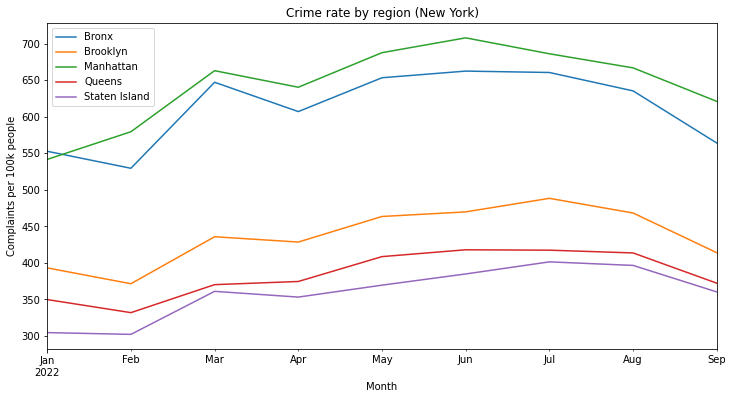

In [65]:
for row in crime_table.T:
  crime_table.loc[row].plot(label=row.title())

plt.legend()
plt.ylabel('Complaints per 100k people')
plt.xlabel('Month')
plt.title('Crime rate by region (New York)')
plt.gcf().set_size_inches(12, 6)
plt.show()

It looks like the boroughs all share a similar trend in crime rate, peaking between May and August.

### Ratings vs. home value index (ZHVI)

Now, let's use Zillow's month Home Value Index data to associate each listing with the ZHVI of the corresponding neighborhood and month. Note that, unlike the crime data, this home value data contains a column for the neighborhood (more specific than the borough), so we are able to perform more specific regional analysis.

In [66]:
df_home2 = df_home[df_home['City'] == 'New York']
df_home2

RegionID  SizeRank          RegionName    RegionType StateName State  \
3        270957         3     Upper East Side  neighborhood        NY    NY   
5        270958         5     Upper West Side  neighborhood        NY    NY   
9        272902         9  Bedford-Stuyvesant  neighborhood        NY    NY   
10       194430        10       East New York  neighborhood        NY    NY   
14       198687        14  Washington Heights  neighborhood        NY    NY   
...         ...       ...                 ...           ...       ...   ...   
7767     403199      8652            Grasmere  neighborhood        NY    NY   
9143     272982     10330              Travis  neighborhood        NY    NY   
10332     10562     11821       Broad Channel  neighborhood        NY    NY   
12350    270870     14334     Lighthouse Hill  neighborhood        NY    NY   
14176     42662     16633            Neponsit  neighborhood        NY    NY   

           City                                  Metro       CountyName  \
3      New York  New York-Newark-Jersey City, NY-NJ-PA  New York County   
5      New York  New York-Newark-Jersey City, NY-NJ-PA  New York County   
9      New York  New York-Newark-Jersey City, NY-NJ-PA     Kings County   
10     New York  New York-Newark-Jersey City, NY-NJ-PA     Kings County   
14     New York  New York-Newark-Jersey City, NY-NJ-PA  New York County   
...         ...                                    ...              ...   
7767   New York  New York-Newark-Jersey City, NY-NJ-PA  Richmond County   
9143   New York  New York-Newark-Jersey City, NY-NJ-PA  Richmond County   
10332  New York  New York-Newark-Jersey City, NY-NJ-PA    Queens County   
12350  New York  New York-Newark-Jersey City, NY-NJ-PA  Richmond County   
14176  New York  New York-Newark-Jersey City, NY-NJ-PA    Queens County   

       2000-01-31  ...  2021-12-31  2022-01-31  2022-02-28  2022-03-31  \
3        557053.0  ...   1358020.0   1365810.0   1376961.0   1392346.0   
5        390078.0  ...   1394798.0   1402505.0   1415215.0   1435075.0   
9        166345.0  ...   1021828.0   1028504.0   1035132.0   1046095.0   
10       176169.0  ...    572827.0    574932.0    577874.0    582197.0   
14       244266.0  ...    611587.0    614478.0    617980.0    621918.0   
...           ...  ...         ...         ...         ...         ...   
7767     259654.0  ...    721462.0    728006.0    735311.0    744456.0   
9143     160593.0  ...    582465.0    586678.0    592687.0    600267.0   
10332         NaN  ...    558647.0    561742.0    561231.0    563538.0   
12350    365052.0  ...   1126377.0   1132734.0   1143161.0   1155901.0   
14176    794222.0  ...   1413548.0   1433334.0   1446676.0   1454563.0   

       2022-04-30  2022-05-31  2022-06-30  2022-07-31  2022-08-31  2022-09-30  
3       1408048.0   1422654.0   1430734.0   1433236.0   1434060.0   1434378.0  
5       1452768.0   1470227.0   1479307.0   1484624.0   1488264.0   1489225.0  
9       1055985.0   1065453.0   1076552.0   1084743.0   1090869.0   1093653.0  
10       587026.0    590702.0    594009.0    595289.0    597646.0    598937.0  
14       626174.0    630546.0    634720.0    636812.0    636651.0    634574.0  
...           ...         ...         ...         ...         ...         ...  
7767     752658.0    761750.0    767024.0    768281.0    765131.0    762808.0  
9143     608643.0    617995.0    624042.0    627972.0    629036.0    631383.0  
10332    567032.0    575944.0    575358.0    576613.0    574897.0    577612.0  
12350   1170399.0   1183791.0   1193762.0   1205383.0   1215080.0   1221911.0  
14176   1453158.0   1448692.0   1448541.0   1444269.0   1441122.0   1427842.0  

[202 rows x 282 columns]

In [67]:
l1 = df_listings['neighbourhood_cleansed'].unique()
l2 = df_home2['RegionName'].unique()

print(len(l1))
print(len(l2))
print(len(list(set(l1).intersection(l2))))

241
201
169


In [68]:
print(df_home2['RegionName'].value_counts())
df_home2[df_home2['RegionName'] == 'Sunnyside']

# Two neighborhoods named "Sunnyside"...

Sunnyside          2
Upper East Side    1
Douglaston         1
Battery Park       1
Floral park        1
                  ..
Bath Beach         1
Throggs Neck       1
Castle Hill        1
Bedford Park       1
Neponsit           1
Name: RegionName, Length: 201, dtype: int64


RegionID  SizeRank RegionName    RegionType StateName State      City  \
353     275620       373  Sunnyside  neighborhood        NY    NY  New York   
4637    198296      5073  Sunnyside  neighborhood        NY    NY  New York   

                                      Metro       CountyName  2000-01-31  ...  \
353   New York-Newark-Jersey City, NY-NJ-PA    Queens County    137578.0  ...   
4637  New York-Newark-Jersey City, NY-NJ-PA  Richmond County    219632.0  ...   

      2021-12-31  2022-01-31  2022-02-28  2022-03-31  2022-04-30  2022-05-31  \
353     667626.0    667445.0    665592.0    667224.0    670583.0    677641.0   
4637    644819.0    647874.0    653591.0    661888.0    671307.0    679289.0   

      2022-06-30  2022-07-31  2022-08-31  2022-09-30  
353     678996.0    678089.0    676363.0    676994.0  
4637    682345.0    685145.0    683637.0    685360.0  

[2 rows x 282 columns]

In [69]:
df_listings[df_listings['neighbourhood_cleansed'] == 'Sunnyside']['neighbourhood_group_cleansed'].value_counts()

# Sunnyside refers to the Queens neighborhood in the listings DF so we can drop the Richmond one

Queens    225
Name: neighbourhood_group_cleansed, dtype: int64

In [70]:
df_home2 = df_home2.drop(4637)
df_home2 = df_home2.set_index('RegionName')
df_home2

RegionID  SizeRank    RegionType StateName State  \
RegionName                                                             
Upper East Side       270957         3  neighborhood        NY    NY   
Upper West Side       270958         5  neighborhood        NY    NY   
Bedford-Stuyvesant    272902         9  neighborhood        NY    NY   
East New York         194430        10  neighborhood        NY    NY   
Washington Heights    198687        14  neighborhood        NY    NY   
...                      ...       ...           ...       ...   ...   
Grasmere              403199      8652  neighborhood        NY    NY   
Travis                272982     10330  neighborhood        NY    NY   
Broad Channel          10562     11821  neighborhood        NY    NY   
Lighthouse Hill       270870     14334  neighborhood        NY    NY   
Neponsit               42662     16633  neighborhood        NY    NY   

                        City                                  Metro  \
RegionName                                                            
Upper East Side     New York  New York-Newark-Jersey City, NY-NJ-PA   
Upper West Side     New York  New York-Newark-Jersey City, NY-NJ-PA   
Bedford-Stuyvesant  New York  New York-Newark-Jersey City, NY-NJ-PA   
East New York       New York  New York-Newark-Jersey City, NY-NJ-PA   
Washington Heights  New York  New York-Newark-Jersey City, NY-NJ-PA   
...                      ...                                    ...   
Grasmere            New York  New York-Newark-Jersey City, NY-NJ-PA   
Travis              New York  New York-Newark-Jersey City, NY-NJ-PA   
Broad Channel       New York  New York-Newark-Jersey City, NY-NJ-PA   
Lighthouse Hill     New York  New York-Newark-Jersey City, NY-NJ-PA   
Neponsit            New York  New York-Newark-Jersey City, NY-NJ-PA   

                         CountyName  2000-01-31  2000-02-29  ...  2021-12-31  \
RegionName                                                   ...               
Upper East Side     New York County    557053.0    561033.0  ...   1358020.0   
Upper West Side     New York County    390078.0    394094.0  ...   1394798.0   
Bedford-Stuyvesant     Kings County    166345.0    167849.0  ...   1021828.0   
East New York          Kings County    176169.0    176493.0  ...    572827.0   
Washington Heights  New York County    244266.0    249494.0  ...    611587.0   
...                             ...         ...         ...  ...         ...   
Grasmere            Richmond County    259654.0    261280.0  ...    721462.0   
Travis              Richmond County    160593.0    161286.0  ...    582465.0   
Broad Channel         Queens County         NaN         NaN  ...    558647.0   
Lighthouse Hill     Richmond County    365052.0    372185.0  ...   1126377.0   
Neponsit              Queens County    794222.0    801035.0  ...   1413548.0   

                    2022-01-31  2022-02-28  2022-03-31  2022-04-30  \
RegionName                                                           
Upper East Side      1365810.0   1376961.0   1392346.0   1408048.0   
Upper West Side      1402505.0   1415215.0   1435075.0   1452768.0   
Bedford-Stuyvesant   1028504.0   1035132.0   1046095.0   1055985.0   
East New York         574932.0    577874.0    582197.0    587026.0   
Washington Heights    614478.0    617980.0    621918.0    626174.0   
...                        ...         ...         ...         ...   
Grasmere              728006.0    735311.0    744456.0    752658.0   
Travis                586678.0    592687.0    600267.0    608643.0   
Broad Channel         561742.0    561231.0    563538.0    567032.0   
Lighthouse Hill      1132734.0   1143161.0   1155901.0   1170399.0   
Neponsit             1433334.0   1446676.0   1454563.0   1453158.0   

                    2022-05-31  2022-06-30  2022-07-31  2022-08-31  2022-09-30  
RegionName                                                                      
Upper East Side      1422654.0   1430734.0   

In [71]:
# Filter to relevant (or potentially relevant) columns
df_listings2 = df_listings[['id', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'price', 'review_scores_rating', 'review_scores_location', 'date']].copy()
df_listings2 = df_listings2.dropna(subset=['review_scores_location'])
df_listings2['price'] = df_listings2['price'].apply(lambda s: re.sub('[$,]', '', s)).astype(float)
df_listings2['month_end'] = (df_listings2['date'].dt.to_period('M').dt.to_timestamp() 
  + pd.offsets.MonthEnd(0)).dt.strftime('%Y-%m-%d')

df_listings2

id neighbourhood_cleansed neighbourhood_group_cleansed  price  \
0          2539             Kensington                     Brooklyn  299.0   
1          2595                Midtown                    Manhattan  175.0   
2          5121     Bedford-Stuyvesant                     Brooklyn   60.0   
3         45910              Ridgewood                       Queens  425.0   
4          5136            Sunset Park                     Brooklyn  275.0   
...         ...                    ...                          ...    ...   
39873  42971489           West Village                    Manhattan  150.0   
39876  43728504          Rockaway Park                       Queens  157.0   
39877  44578886        Upper West Side                    Manhattan  108.0   
39878  46355090              Bellerose                       Queens  140.0   
39880  48971505           Ellis Island                    Manhattan   40.0   

       review_scores_rating  review_scores_location       date   month_end  
0                      4.89                    4.75 2018-10-19  2018-10-31  
1                      4.68                    4.81 2022-06-21  2022-06-30  
2                      4.52                    4.47 2019-12-02  2019-12-31  
3                      4.42                    4.82 2019-11-12  2019-11-30  
4                      5.00                    4.67 2022-08-10  2022-08-31  
...                     ...                     ...        ...         ...  
39873                  5.00                    5.00 2022-08-19  2022-08-31  
39876                  4.91                    4.94 2022-09-05  2022-09-30  
39877                  4.79                    4.81 2022-09-04  2022-09-30  
39878                  4.45                    4.36 2022-08-17  2022-08-31  
39880                  4.47                    4.87 2021-10-25  2021-10-31  

[31049 rows x 8 columns]

In [72]:
# Filter to compatible neighborhoods
df_listings3 = df_listings2[df_listings2['neighbourhood_cleansed'].isin(df_home2.index)].copy()
df_listings3

id neighbourhood_cleansed neighbourhood_group_cleansed  price  \
0          2539             Kensington                     Brooklyn  299.0   
1          2595                Midtown                    Manhattan  175.0   
2          5121     Bedford-Stuyvesant                     Brooklyn   60.0   
3         45910              Ridgewood                       Queens  425.0   
4          5136            Sunset Park                     Brooklyn  275.0   
...         ...                    ...                          ...    ...   
39872  35372621        Upper West Side                    Manhattan   69.0   
39873  42971489           West Village                    Manhattan  150.0   
39876  43728504          Rockaway Park                       Queens  157.0   
39877  44578886        Upper West Side                    Manhattan  108.0   
39878  46355090              Bellerose                       Queens  140.0   

       review_scores_rating  review_scores_location       date   month_end  
0                      4.89                    4.75 2018-10-19  2018-10-31  
1                      4.68                    4.81 2022-06-21  2022-06-30  
2                      4.52                    4.47 2019-12-02  2019-12-31  
3                      4.42                    4.82 2019-11-12  2019-11-30  
4                      5.00                    4.67 2022-08-10  2022-08-31  
...                     ...                     ...        ...         ...  
39872                  5.00                    5.00 2019-08-24  2019-08-31  
39873                  5.00                    5.00 2022-08-19  2022-08-31  
39876                  4.91                    4.94 2022-09-05  2022-09-30  
39877                  4.79                    4.81 2022-09-04  2022-09-30  
39878                  4.45                    4.36 2022-08-17  2022-08-31  

[27927 rows x 8 columns]

In [73]:
# Get home value index for particular neighborhood and month
df_listings3['zhvi'] = df_listings3.apply(lambda x: df_home2.loc[x['neighbourhood_cleansed']][x['month_end']], axis=1)

In [74]:
df_listings3 = df_listings3.dropna(subset=['zhvi'])
df_listings3

id neighbourhood_cleansed neighbourhood_group_cleansed  price  \
0          2539             Kensington                     Brooklyn  299.0   
1          2595                Midtown                    Manhattan  175.0   
2          5121     Bedford-Stuyvesant                     Brooklyn   60.0   
3         45910              Ridgewood                       Queens  425.0   
4          5136            Sunset Park                     Brooklyn  275.0   
...         ...                    ...                          ...    ...   
39872  35372621        Upper West Side                    Manhattan   69.0   
39873  42971489           West Village                    Manhattan  150.0   
39876  43728504          Rockaway Park                       Queens  157.0   
39877  44578886        Upper West Side                    Manhattan  108.0   
39878  46355090              Bellerose                       Queens  140.0   

       review_scores_rating  review_scores_location       date   month_end  \
0                      4.89                    4.75 2018-10-19  2018-10-31   
1                      4.68                    4.81 2022-06-21  2022-06-30   
2                      4.52                    4.47 2019-12-02  2019-12-31   
3                      4.42                    4.82 2019-11-12  2019-11-30   
4                      5.00                    4.67 2022-08-10  2022-08-31   
...                     ...                     ...        ...         ...   
39872                  5.00                    5.00 2019-08-24  2019-08-31   
39873                  5.00                    5.00 2022-08-19  2022-08-31   
39876                  4.91                    4.94 2022-09-05  2022-09-30   
39877                  4.79                    4.81 2022-09-04  2022-09-30   
39878                  4.45                    4.36 2022-08-17  2022-08-31   

            zhvi  
0       854566.0  
1      1550633.0  
2       925096.0  
3       772086.0  
4       643149.0  
...          ...  
39872  1374198.0  
39873  2199214.0  
39876   529045.0  
39877  1489225.0  
39878   742789.0  

[27900 rows x 9 columns]

Our data have now been cleaned and merged. Now, we can perform EDA and even some preliminary simple regression analysis.

In [75]:
df_listings3['date'].describe()

<ipython-input-75-628e86546a7e>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_listings3['date'].describe()


count                   27900
unique                   2555
top       2022-09-05 00:00:00
freq                     1024
first     2011-05-12 00:00:00
last      2022-09-07 00:00:00
Name: date, dtype: object

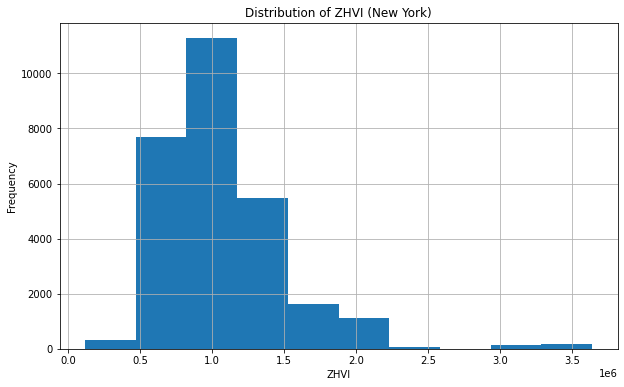

In [76]:
# Plot distribution of ZHVI of listings
df_listings3['zhvi'].hist()
plt.xlabel('ZHVI')
plt.ylabel('Frequency')
plt.title('Distribution of ZHVI (New York)')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [77]:
def regress(x, y):
  return sm.OLS(y, sm.add_constant(x)).fit().summary()

In [78]:
regress(df_listings3['price'], df_listings3['review_scores_rating'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.001
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     13.99
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):           0.000184
Time:                          04:27:05   Log-Likelihood:                -19337.
No. Observations:                 27900   AIC:                         3.868e+04
Df Residuals:                     27898   BIC:                         3.869e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6883      0.003   1366.434      0.000       4.682       4.695
price       3.737e-05   9.99e-06      3.741      0.000    1.78e-05     5.7e-05
==============================================================================
Omnibus:                    24097.629   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           761405.033
Skew:                          -4.137   Prob(JB):                         0.00
Kurtosis:                      27.218   Cond. No.                         407.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
regress(df_listings3['zhvi'], df_listings3['review_scores_location'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     review_scores_location   R-squared:                       0.039
Model:                                OLS   Adj. R-squared:                  0.039
Method:                     Least Squares   F-statistic:                     1142.
Date:                    Sat, 03 Dec 2022   Prob (F-statistic):          1.92e-245
Time:                            04:27:05   Log-Likelihood:                -14012.
No. Observations:                   27900   AIC:                         2.803e+04
Df Residuals:                       27898   BIC:                         2.804e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5469      0.006    725.195      0.000       4.535       4.559
zhvi        1.821e-07   5.39e-09     33.798      0.000    1.72e-07    1.93e-07
==============================================================================
Omnibus:                    26254.774   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1331717.615
Skew:                          -4.541   Prob(JB):                         0.00
Kurtosis:                      35.605   Cond. No.                     3.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

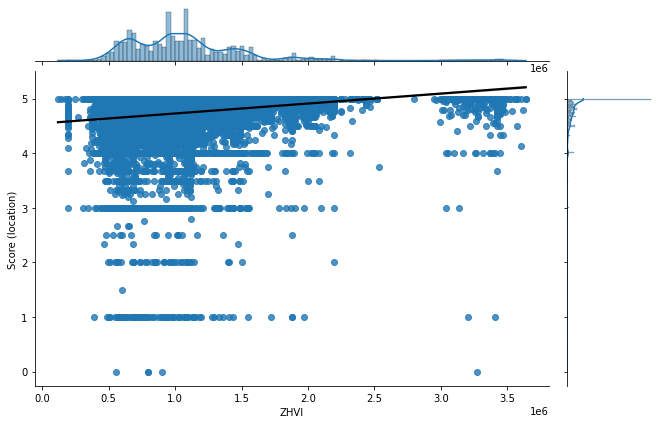

In [80]:
ax = sns.jointplot(x=df_listings3['zhvi'], y=df_listings3['review_scores_location'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
ax.set_axis_labels('ZHVI', 'Score (location)')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [81]:
regress(df_listings3['zhvi'], df_listings3['price'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1155.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):          3.83e-248
Time:                        04:27:09   Log-Likelihood:            -1.9721e+05
No. Observations:               27900   AIC:                         3.944e+05
Df Residuals:                   27898   BIC:                         3.944e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.9962      4.456      9.874      0.000      35.263      52.730
zhvi           0.0001   3.83e-06     33.988      0.000       0.000       0.000
==============================================================================
Omnibus:                    62061.776   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        489592616.132
Skew:                          20.704   Prob(JB):                         0.00
Kurtosis:                     650.642   Cond. No.                     3.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

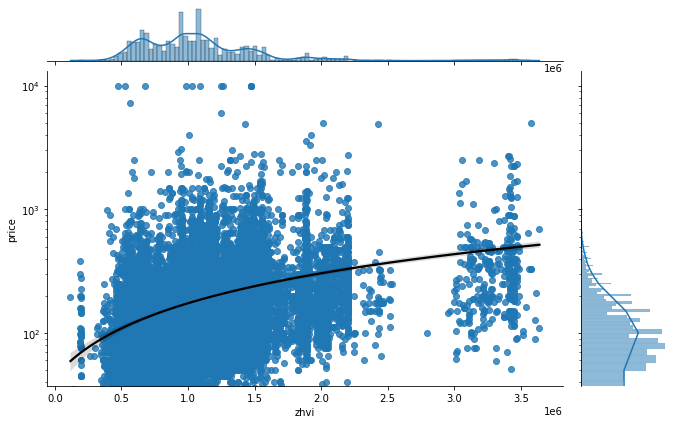

In [82]:
sns.jointplot(x=df_listings3['zhvi'], y=df_listings3['price'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.yscale('log')
plt.show()

We see that scores, price, and home value are weakly correlated with each other. We'll explore this more in our multiple regression analysis.

### Ratings vs. hotel index

Now, let's perform a similar analysis with Trivago's Hotel Value Index data. Unfortunately, this dataset is more limited in that it only contains index data for all of New York and for each of the past 12 months, so we are only ably conduct analysis based on time, not region.

In [83]:
df_hotel2 = df_hotel.set_index('City')
nyc_hotel = df_hotel2.loc['New York'].apply(lambda s: re.sub('[$,]', '', s)).astype(float)
nyc_hotel

Oct-21    298.0
Nov-21    285.0
Dec-21    385.0
Jan-22    235.0
Feb-22    227.0
Mar-22    259.0
Apr-22    345.0
May-22    377.0
Jun-22    388.0
Jul-22    343.0
Aug-22    338.0
Sep-22    435.0
Oct-22    433.0
Name: New York, dtype: float64

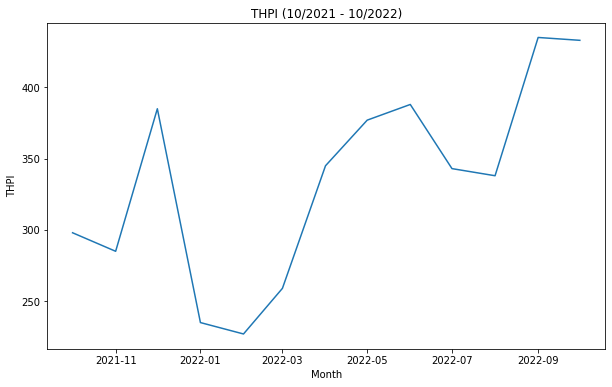

In [84]:
# Plot index data as time series
plt.plot(pd.to_datetime(nyc_hotel.index, format='%b-%y'), nyc_hotel)
plt.gcf().set_size_inches(10, 6)
plt.xlabel('Month')
plt.ylabel('THPI')
plt.title('THPI (10/2021 - 10/2022)')
plt.show()

In [85]:
cutoff = pd.to_datetime('10/01/2021')
df_listings4 = df_listings[df_listings['date'] >= cutoff].copy()

In [86]:
pd.to_datetime(nyc_hotel.index, format='%b-%y').strftime('%m-%y')

Index(['10-21', '11-21', '12-21', '01-22', '02-22', '03-22', '04-22', '05-22',
       '06-22', '07-22', '08-22', '09-22', '10-22'],
      dtype='object')

In [87]:
# Add hotel index as new column and add/re-format other columns
df_listings4['month'] = pd.to_datetime(df_listings4['date']).dt.strftime('%b-%y')
df_listings4['hotel_index'] = df_listings4['month'].map(nyc_hotel.to_dict())
df_listings4['price'] = df_listings4['price'].apply(lambda s: re.sub('[$,]', '', s)).astype(float)
df_listings4

id                            listing_url       scrape_id  \
1          2595      https://www.airbnb.com/rooms/2595  20220907064715   
4          5136      https://www.airbnb.com/rooms/5136  20220907064715   
6         77765     https://www.airbnb.com/rooms/77765  20220907064715   
7          5178      https://www.airbnb.com/rooms/5178  20220907064715   
8         80493     https://www.airbnb.com/rooms/80493  20220907064715   
...         ...                                    ...             ...   
39873  42971489  https://www.airbnb.com/rooms/42971489  20220907064715   
39876  43728504  https://www.airbnb.com/rooms/43728504  20220907064715   
39877  44578886  https://www.airbnb.com/rooms/44578886  20220907064715   
39878  46355090  https://www.airbnb.com/rooms/46355090  20220907064715   
39880  48971505  https://www.airbnb.com/rooms/48971505  20220907064715   

      last_scraped           source                                      name  \
1       2022-09-07      city scrape                     Skylit Midtown Castle   
4       2022-09-07      city scrape  Spacious Brooklyn Duplex, Patio + Garden   
6       2022-09-07      city scrape                      Superior @ Box House   
7       2022-09-07      city scrape          Large Furnished Room Near B'way　   
8       2022-09-07      city scrape         Cozy room in East Village with AC   
...            ...              ...                                       ...   
39873   2022-09-08  previous scrape              2Bdrm Great Hoboken Location   
39876   2022-09-08  previous scrape         Private Modern House by The Beach   
39877   2022-09-08  previous scrape      Beautiful apartment - minutes to NYC   
39878   2022-09-08  previous scrape       1 Bedroom Basement, NEWLY Renovated   
39880   2022-09-08  previous scrape  Just Blocks to Grove PATH and JC Med Ctr   

                                             description  \
1      Beautiful, spacious skylit studio in the heart...   
4      We welcome you to stay in our lovely 2 br dupl...   
6      <b>The space</b><br />Charming standard queen ...   
7      Please don’t expect the luxury here just a bas...   
8      This room is up three flights of stairs - it's...   
...                                                  ...   
39873  LOCATION LOCATION LOCATION!<br />HOBOKEN 2Bdrm...   
39876  Private modern house by the Beach with all com...   
39877  Our apartment is straight across the river fro...   
39878  With easy access to multiple bus stops and the...   
39880  Very convenient to the Grove St PATH (5 min wa...   

                                   neighborhood_overview  \
1      Centrally located in the heart of Manhattan ju...   
4                                                    NaN   
6                                                    NaN   
7        Theater district, many restaurants around here.   
8      People are easy going here, they're not in suc...   
...                                                  ...   
39873  Located on Third & Garden, this apartment is r...   
39876  Rockaway Beach is a neighborhood that gives it...   
39877  Our apartment is located in a very interesting...   
39878                                                NaN   
39880                                                NaN   

                                             picture_url    host_id  ...  \
1      https://a0.muscache.com/pictures/f0813a11-40b2...       2845  ...   
4      https://a0.muscache.com/pictures/miso/Hosting-...       7378  ...   
6      https://a0.muscache.com/pictures/fe864e89-6454...     417504  ...   
7      https://a0.muscache.com/pictures/12065/f070997...       8967  ...   
8      https://a0.muscache.com/pictures/888e6a80-ef85...     434987  ...   
...                                                  ...        ...  ...   
39873  https://a0.muscache.com/pictures/de0b6de2-436c...   40898359  ...   
39876  https://a0.muscache.com/pictures/6c950656-b090...   23049030  ...   
39877  https://a0.muscach

Now that we've added the hotel index as a column, we can now perform some preliminary simple regression analysis, like we did for ZHVI.

In [88]:
regress(df_listings4['hotel_index'], df_listings4['price'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2329
Date:                Sat, 03 Dec 2022   Prob (F-statistic):              0.629
Time:                        04:27:15   Log-Likelihood:            -1.3896e+05
No. Observations:               20158   AIC:                         2.779e+05
Df Residuals:                   20156   BIC:                         2.779e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         189.0388     12.686     14.901      0.000     164.173     213.905
hotel_index     0.0171      0.035      0.483      0.629      -0.052       0.086
==============================================================================
Omnibus:                    41402.741   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        295361263.422
Skew:                          17.009   Prob(JB):                         0.00
Kurtosis:                     595.029   Cond. No.                     2.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

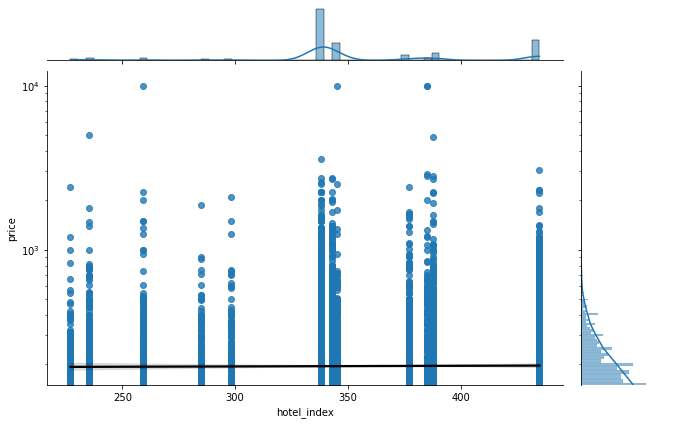

In [89]:
sns.jointplot(x=df_listings4['hotel_index'], y=df_listings4['price'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.yscale('log')
plt.show()

# Hard to use hotel index data since it is based on the entire city of New York
# So we cannot separate into boroughs, neighborhoods, etc.

In [90]:
regress(df_listings4['hotel_index'], df_listings4['review_scores_rating'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.005
Model:                              OLS   Adj. R-squared:                  0.005
Method:                   Least Squares   F-statistic:                     107.5
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):           3.96e-25
Time:                          04:27:22   Log-Likelihood:                -11790.
No. Observations:                 20158   AIC:                         2.358e+04
Df Residuals:                     20156   BIC:                         2.360e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.4777      0.023    193.909      0.000       4.432       4.523
hotel_index     0.0007   6.44e-05     10.369      0.000       0.001       0.001
==============================================================================
Omnibus:                    18347.319   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           749182.707
Skew:                          -4.384   Prob(JB):                         0.00
Kurtosis:                      31.550   Cond. No.                     2.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

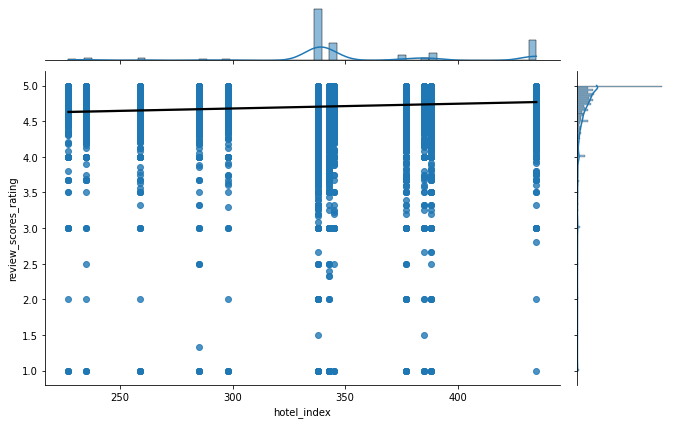

In [91]:
sns.jointplot(x=df_listings4['hotel_index'], y=df_listings4['review_scores_rating'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.show()

Similar to ZHVI, we find positive correlations among scores, price, and hotel value. These seem to be somewhat weaker, probably because we did not have any categorization by regions.

### Joint analysis

We have already performed some simple regression analysis on the external datasets, but the main goal of the previous sections was to clean and extract the extrinsic variables we want. Now, we can perform a more comprehensive multiple regression analysis that incorporates all of these variables.

In [92]:
# Merge listings data from previous sections
cutoff = pd.to_datetime('01/01/2022')
df_total = df_listings3.merge(df_listings4[['id', 'hotel_index']], on='id')
df_total = df_total[df_total['date'] >= cutoff]
df_total['month_start'] = df_total['date'].dt.to_period('M').dt.to_timestamp()
df_total['crime_rate_100k'] = df_total.apply(lambda x: crime_table.loc[x['neighbourhood_group_cleansed'].upper()][x['month_start']], axis=1)
df_total

id neighbourhood_cleansed neighbourhood_group_cleansed  price  \
0          2595                Midtown                    Manhattan  175.0   
1          5136            Sunset Park                     Brooklyn  275.0   
2         77765             Greenpoint                     Brooklyn  308.0   
3          5178                Midtown                    Manhattan   68.0   
4         80493           East Village                    Manhattan   55.0   
...         ...                    ...                          ...    ...   
18050  38361585        Cambria Heights                       Queens  125.0   
18051  42971489           West Village                    Manhattan  150.0   
18052  43728504          Rockaway Park                       Queens  157.0   
18053  44578886        Upper West Side                    Manhattan  108.0   
18054  46355090              Bellerose                       Queens  140.0   

       review_scores_rating  review_scores_location       date   month_end  \
0                      4.68                    4.81 2022-06-21  2022-06-30   
1                      5.00                    4.67 2022-08-10  2022-08-31   
2                      4.90                    4.46 2022-07-18  2022-07-31   
3                      4.23                    4.88 2022-08-22  2022-08-31   
4                      4.34                    4.82 2022-08-13  2022-08-31   
...                     ...                     ...        ...         ...   
18050                  5.00                    5.00 2022-08-30  2022-08-31   
18051                  5.00                    5.00 2022-08-19  2022-08-31   
18052                  4.91                    4.94 2022-09-05  2022-09-30   
18053                  4.79                    4.81 2022-09-04  2022-09-30   
18054                  4.45                    4.36 2022-08-17  2022-08-31   

            zhvi  hotel_index month_start  crime_rate_100k  
0      1550633.0        388.0  2022-06-01       708.036474  
1       643149.0        338.0  2022-08-01       468.298738  
2      1186848.0        343.0  2022-07-01       488.400533  
3      1559068.0        338.0  2022-08-01       666.956665  
4      1394710.0        338.0  2022-08-01       666.956665  
...          ...          ...         ...              ...  
18050   650088.0        338.0  2022-08-01       413.641609  
18051  2199214.0        338.0  2022-08-01       666.956665  
18052   529045.0        435.0  2022-09-01       372.235876  
18053  1489225.0        435.0  2022-09-01       621.096016  
18054   742789.0        338.0  2022-08-01       413.641609  

[17219 rows x 12 columns]

In [93]:
df_total['date'].describe()

<ipython-input-93-c480832b6817>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_total['date'].describe()


count                   17219
unique                    250
top       2022-09-05 00:00:00
freq                     1024
first     2022-01-01 00:00:00
last      2022-09-07 00:00:00
Name: date, dtype: object

In [94]:
regress(df_total['zhvi'], df_total['hotel_index'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hotel_index   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     44.96
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           2.07e-11
Time:                        04:27:34   Log-Likelihood:                -90749.
No. Observations:               17219   AIC:                         1.815e+05
Df Residuals:                   17217   BIC:                         1.815e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        362.6406      0.971    373.304      0.000     360.737     364.545
zhvi       -5.665e-06   8.45e-07     -6.705      0.000   -7.32e-06   -4.01e-06
==============================================================================
Omnibus:                      232.699   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.836
Skew:                          -0.072   Prob(JB):                     3.72e-90
Kurtosis:                       3.744   Cond. No.                     3.11e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

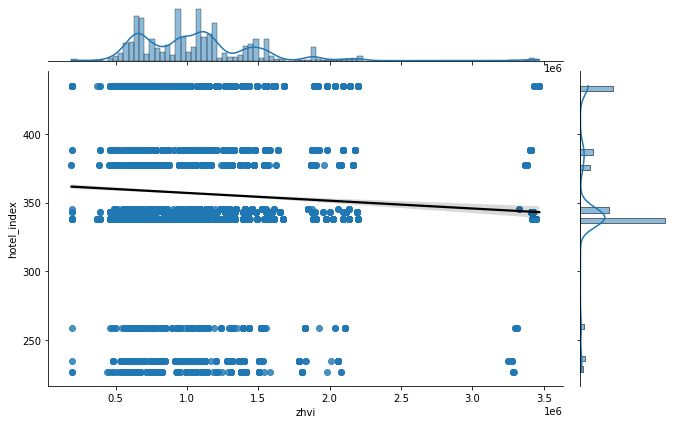

In [95]:
sns.jointplot(x=df_total['zhvi'], y=df_total['hotel_index'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.show()

In [96]:
regress(df_total['crime_rate_100k'], df_total['zhvi'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   zhvi   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     3492.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        04:27:37   Log-Likelihood:            -2.4598e+05
No. Observations:               17219   AIC:                         4.920e+05
Df Residuals:                   17217   BIC:                         4.920e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.658e+05   1.39e+04     19.122      0.000    2.39e+05    2.93e+05
crime_rate_100k  1516.8321     25.667     59.096      0.000    1466.522    1567.142
==============================================================================
Omnibus:                     6191.262   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43823.582
Skew:                           1.551   Prob(JB):                         0.00
Kurtosis:                      10.174   Cond. No.                     2.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

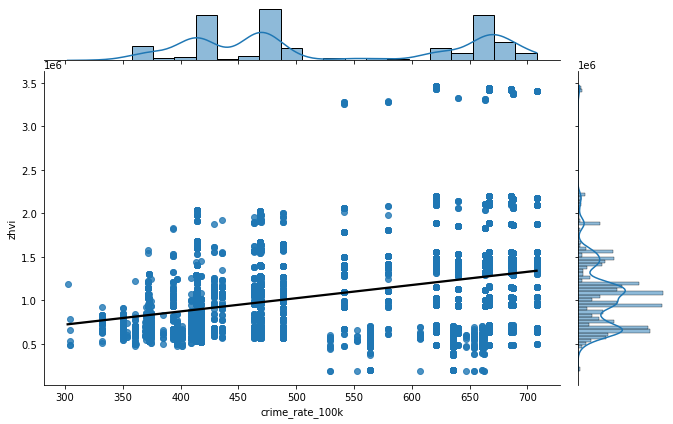

In [97]:
sns.jointplot(x=df_total['crime_rate_100k'], y=df_total['zhvi'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.show()

In [98]:
regress(df_total[['price', 'zhvi', 'hotel_index', 'crime_rate_100k']], df_total['review_scores_rating'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.011
Model:                              OLS   Adj. R-squared:                  0.010
Method:                   Least Squares   F-statistic:                     46.58
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):           5.33e-39
Time:                          04:27:40   Log-Likelihood:                -9467.4
No. Observations:                 17219   AIC:                         1.894e+04
Df Residuals:                     17214   BIC:                         1.898e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.6001      0.030    153.510      0.000       4.541       4.659
price             9.55e-05   1.51e-05      6.331      0.000    6.59e-05       0.000
zhvi             2.509e-08   8.45e-09      2.968      0.003    8.52e-09    4.17e-08
hotel_index         0.0006   6.82e-05      8.559      0.000       0.000       0.001
crime_rate_100k    -0.0002   3.07e-05     -8.120      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    16040.705   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           729663.441
Skew:                          -4.505   Prob(JB):                         0.00
Kurtosis:                      33.591   Cond. No.                     1.08e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here, we see that price, ZHVI, THPI (hotel index), and crime rate are all significant predictors. All except crime rate are positively correlated, suggesting that higher overall scores are associated with more affluent, less dangerous areas.

In [99]:
regress(df_total[['price', 'zhvi', 'hotel_index', 'crime_rate_100k']], df_total['review_scores_location'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     review_scores_location   R-squared:                       0.047
Model:                                OLS   Adj. R-squared:                  0.046
Method:                     Least Squares   F-statistic:                     210.4
Date:                    Sat, 03 Dec 2022   Prob (F-statistic):          1.62e-176
Time:                            04:27:40   Log-Likelihood:                -6971.8
No. Observations:                   17219   AIC:                         1.395e+04
Df Residuals:                       17214   BIC:                         1.399e+04
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.4216      0.026    170.564      0.000       4.371       4.472
price            5.032e-05   1.31e-05      3.856      0.000    2.47e-05    7.59e-05
zhvi             1.756e-07   7.31e-09     24.012      0.000    1.61e-07     1.9e-07
hotel_index         0.0003    5.9e-05      5.092      0.000       0.000       0.000
crime_rate_100k   2.93e-05   2.66e-05      1.102      0.270   -2.28e-05    8.14e-05
==============================================================================
Omnibus:                    16308.818   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           880858.466
Skew:                          -4.555   Prob(JB):                         0.00
Kurtosis:                      36.834   Cond. No.                     1.08e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see mostly similar trends for the location score model, except crime rate is notably not a significant predictor.

## San Francisco model

We now apply the same pipeline and analysis to the San Francisco datasets. First, let's clean the data.

In [100]:
pd.set_option('display.max_columns', None)
print(df_listings_sf.info())
df_listings_sf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6629 entries, 0 to 6628
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6629 non-null   int64  
 1   listing_url                                   6629 non-null   object 
 2   scrape_id                                     6629 non-null   int64  
 3   last_scraped                                  6629 non-null   object 
 4   source                                        6629 non-null   object 
 5   name                                          6629 non-null   object 
 6   description                                   6577 non-null   object 
 7   neighborhood_overview                         4700 non-null   object 
 8   picture_url                                   6629 non-null   object 
 9   host_id                                       6629 non-null   i

id                          listing_url       scrape_id last_scraped  \
0     958     https://www.airbnb.com/rooms/958  20220907064650   2022-09-07   
1    5858    https://www.airbnb.com/rooms/5858  20220907064650   2022-09-07   
2    8014    https://www.airbnb.com/rooms/8014  20220907064650   2022-09-07   
3  148627  https://www.airbnb.com/rooms/148627  20220907064650   2022-09-07   
4  494111  https://www.airbnb.com/rooms/494111  20220907064650   2022-09-07   

            source                                     name  \
0      city scrape    Bright, Modern Garden Unit - 1BR/1BTH   
1      city scrape                       Creative Sanctuary   
2  previous scrape  room in FEMALE house WIFI market nearby   
3      city scrape            Romantic Marina Garden Studio   
4      city scrape      Comfortable space of your own in SF   

                                         description  \
0  Please check local laws re Covid before you re...   
1  We live in a large Victorian house on a quiet ...   
2  Room is on the second floor so it gets a good ...   
3  Street parking only, please follow all signs.<...   
4  <b>The space</b><br />A beautiful, bright, and...   

                               neighborhood_overview  \
0  Quiet cul de sac in friendly neighborhood<br /...   
1  I love how our neighborhood feels quiet but is...   
2  The neighborhood is very residential, close to...   
3  Super convenient walking access to all the bes...   
4  The location is not considered a traditionally...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/b7c2a199-4c17...     1169   
1  https://a0.muscache.com/pictures/17714/3a7aea1...     8904   
2  https://a0.muscache.com/pictures/2cc1fc3d-0ae0...    22402   
3  https://a0.muscache.com/pictures/3048720/ef73f...   709325   
4  https://a0.muscache.com/pictures/a4c0e7ec-caa1...   252927   

                                   host_url         host_name  host_since  \
0    https://www.airbnb.com/users/show/1169             Holly  2008-07-31   
1    https://www.airbnb.com/users/show/8904  Philip And Tania  2009-03-02   
2   https://www.airbnb.com/users/show/22402               Jia  2009-06-20   
3  https://www.airbnb.com/users/show/709325              Mark  2011-06-16   
4  https://www.airbnb.com/users/show/252927            Vivian  2010-10-04   

       host_location                                         host_about  \
0  San Francisco, CA  We are a family of four that live upstairs.  W...   
1  San Francisco, CA  Philip: English transplant to the Bay Area and...   
2  San Francisco, CA  Airbnbing while we are doing some renovation a...   
3  San Francisco, CA  I am an avid traveler and have visited more th...   
4  San Francisco, CA                                 From San Francisco   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour                90%                  98%   
1       within a day                60%                  70%   
2     within an hour               100%                  90%   
3     within an hour               100%                 100%   
4       within a day               100%                  87%   

  host_is_superhost                                 host_thumbnail_url  \
0                 t  https://a0.muscache.com/im/pictures/user/efdad...   
1                 f  https://a0.muscache.com/im/users/8904/profile_...   
2                 f  https://a0.muscache.com/im/users/22402/profile...   
3                 f  https://a0.muscache.com/im/users/709325/profil...   
4                 t  https://a0.muscache.com/im/users/252927/profil...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/efdad...    Duboce Triangle   
1  https://a0.muscache.com/im/users/8904/profile_...     Bernal Heights   
2  https://a0.muscache.com/im/users/22402/profile...          Sunnyside   
3  https://a0.muscache.com/im/users/709325/p

In [101]:
print(df_crime_sf.info())
df_crime_sf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667960 entries, 0 to 667959
Data columns (total 34 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Incident Datetime                                     667960 non-null  object 
 1   Incident Date                                         667960 non-null  object 
 2   Incident Time                                         667960 non-null  object 
 3   Incident Year                                         667960 non-null  int64  
 4   Incident Day of Week                                  667960 non-null  object 
 5   Report Datetime                                       667960 non-null  object 
 6   Row ID                                                667960 non-null  int64  
 7   Incident ID                                           667960 non-null  int64  
 8   Incident Number                             

Incident Datetime Incident Date Incident Time  Incident Year  \
0  2021/07/25 12:00:00 AM    2021/07/25         00:00           2021   
1  2022/06/28 11:58:00 PM    2022/06/28         23:58           2022   
2  2022/03/11 10:30:00 AM    2022/03/11         10:30           2022   
3  2021/05/15 05:47:00 PM    2021/05/15         17:47           2021   
4  2022/06/28 05:22:00 PM    2022/06/28         17:22           2022   

  Incident Day of Week         Report Datetime        Row ID  Incident ID  \
0               Sunday  2021/07/25 01:41:00 PM  105718906372      1057189   
1              Tuesday  2022/06/28 11:58:00 PM  116554371012      1165543   
2               Friday  2022/03/11 08:03:00 PM  113048071000      1130480   
3             Saturday  2021/05/15 05:47:00 PM  103051807043      1030518   
4              Tuesday  2022/06/28 05:22:00 PM  116535107041      1165351   

   Incident Number  CAD Number Report Type Code Report Type Description  \
0        216105573         NaN               II        Coplogic Initial   
1        220264913         NaN               VS      Vehicle Supplement   
2        226040232         NaN               II        Coplogic Initial   
3        210183345         NaN               VS      Vehicle Supplement   
4        220361741         NaN               VS      Vehicle Supplement   

  Filed Online  Incident Code  Incident Category   Incident Subcategory  \
0         True           6372      Larceny Theft  Larceny Theft - Other   
1          NaN          71012     Other Offenses         Other Offenses   
2         True          71000      Lost Property          Lost Property   
3          NaN           7043  Recovered Vehicle      Recovered Vehicle   
4          NaN           7041  Recovered Vehicle      Recovered Vehicle   

              Incident Description      Resolution Intersection  CNN  \
0  Theft, Other Property, $50-$200  Open or Active          NaN  NaN   
1         License Plate, Recovered  Open or Active          NaN  NaN   
2                    Lost Property  Open or Active          NaN  NaN   
3   Vehicle, Recovered, Motorcycle  Open or Active          NaN  NaN   
4         Vehicle, Recovered, Auto  Open or Active          NaN  NaN   

  Police District Analysis Neighborhood  Supervisor District  Latitude  \
0        Southern                   NaN                  NaN       NaN   
1       Out of SF                   NaN                  NaN       NaN   
2         Central                   NaN                  NaN       NaN   
3       Out of SF                   NaN                  NaN       NaN   
4       Out of SF                   NaN                  NaN       NaN   

   Longitude Point  Neighborhoods  ESNCAG - Boundary File  \
0        NaN   NaN            NaN                     NaN   
1        NaN   NaN            NaN                     NaN   
2        NaN   NaN            NaN                     NaN   
3        NaN   NaN            NaN                     NaN   
4        NaN   NaN            NaN                     NaN   

   Central Market/Tenderloin Boundary Polygon - Updated  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      
4                                                NaN      

   Civic Center Harm Reduction Project Boundary  HSOC Zones as of 2018-06-05  \
0                                           NaN                          NaN   
1                                           NaN                          NaN   
2                                           NaN                          NaN   
3                                           NaN                          NaN   
4                                           NaN                          NaN   

   Invest In Neighborhoods (IIN) Areas  Current Supervisor Districts  \
0                                  NaN                   

In [102]:
print(df_crime_sf.shape)
df_crime_sf.isna().sum()

(667960, 34)


Incident Datetime                                            0
Incident Date                                                0
Incident Time                                                0
Incident Year                                                0
Incident Day of Week                                         0
Report Datetime                                              0
Row ID                                                       0
Incident ID                                                  0
Incident Number                                              0
CAD Number                                              149354
Report Type Code                                             0
Report Type Description                                      0
Filed Online                                            533349
Incident Code                                                0
Incident Category                                          559
Incident Subcategory                                   

In [103]:
df_crime_sf.nunique()

Incident Datetime                                       314607
Incident Date                                             1795
Incident Time                                             1440
Incident Year                                                5
Incident Day of Week                                         7
Report Datetime                                         474866
Row ID                                                  667960
Incident ID                                             557413
Incident Number                                         481803
CAD Number                                              381395
Report Type Code                                             4
Report Type Description                                      6
Filed Online                                                 1
Incident Code                                              836
Incident Category                                           49
Incident Subcategory                                   

In [104]:
np.sort(df_crime_sf['Analysis Neighborhood'].dropna().unique())

array(['Bayview Hunters Point', 'Bernal Heights', 'Castro/Upper Market',
       'Chinatown', 'Excelsior', 'Financial District/South Beach',
       'Glen Park', 'Golden Gate Park', 'Haight Ashbury', 'Hayes Valley',
       'Inner Richmond', 'Inner Sunset', 'Japantown', 'Lakeshore',
       'Lincoln Park', 'Lone Mountain/USF', 'Marina', 'McLaren Park',
       'Mission', 'Mission Bay', 'Nob Hill', 'Noe Valley', 'North Beach',
       'Oceanview/Merced/Ingleside', 'Outer Mission', 'Outer Richmond',
       'Pacific Heights', 'Portola', 'Potrero Hill', 'Presidio',
       'Presidio Heights', 'Russian Hill', 'Seacliff', 'South of Market',
       'Sunset/Parkside', 'Tenderloin', 'Treasure Island', 'Twin Peaks',
       'Visitacion Valley', 'West of Twin Peaks', 'Western Addition'],
      dtype=object)

In [105]:
np.sort(df_listings_sf['neighbourhood_cleansed'].unique())

array(['Bayview', 'Bernal Heights', 'Castro/Upper Market', 'Chinatown',
       'Crocker Amazon', 'Diamond Heights', 'Downtown/Civic Center',
       'Excelsior', 'Financial District', 'Glen Park', 'Golden Gate Park',
       'Haight Ashbury', 'Inner Richmond', 'Inner Sunset', 'Lakeshore',
       'Marina', 'Mission', 'Nob Hill', 'Noe Valley', 'North Beach',
       'Ocean View', 'Outer Mission', 'Outer Richmond', 'Outer Sunset',
       'Pacific Heights', 'Parkside', 'Potrero Hill', 'Presidio',
       'Presidio Heights', 'Russian Hill', 'Seacliff', 'South of Market',
       'Twin Peaks', 'Visitacion Valley', 'West of Twin Peaks',
       'Western Addition'], dtype=object)

In [106]:
replace = {
    'Bayview'           : 'Bayview Hunters Point',
    'Financial District': 'Financial District/South Beach',
    'Ocean View':         'Oceanview/Merced/Ingleside',
    'Outer Sunset':       'Sunset/Parkside',
    'Parkside':           'Sunset/Parkside'
}
df_listings_sf['neighbourhood_cleansed2'] = df_listings_sf['neighbourhood_cleansed'].replace(replace)
np.sort(df_listings_sf['neighbourhood_cleansed2'].unique())

array(['Bayview Hunters Point', 'Bernal Heights', 'Castro/Upper Market',
       'Chinatown', 'Crocker Amazon', 'Diamond Heights',
       'Downtown/Civic Center', 'Excelsior',
       'Financial District/South Beach', 'Glen Park', 'Golden Gate Park',
       'Haight Ashbury', 'Inner Richmond', 'Inner Sunset', 'Lakeshore',
       'Marina', 'Mission', 'Nob Hill', 'Noe Valley', 'North Beach',
       'Oceanview/Merced/Ingleside', 'Outer Mission', 'Outer Richmond',
       'Pacific Heights', 'Potrero Hill', 'Presidio', 'Presidio Heights',
       'Russian Hill', 'Seacliff', 'South of Market', 'Sunset/Parkside',
       'Twin Peaks', 'Visitacion Valley', 'West of Twin Peaks',
       'Western Addition'], dtype=object)

In [107]:
df_home_sf = df_home[df_home['City'] == 'San Francisco']
np.sort(df_home_sf['RegionName'].unique())

array(['Alamo Square', 'Anza Vista', 'Aquatic Park', 'Ashbury Heights',
       'Balboa Terrace', 'Bayview', 'Bernal Heights', 'Bret Harte',
       'Buena Vista', 'Candlestick Point SRA', 'Castro', 'Cathedral Hill',
       'Cayuga', 'Central Waterfront', 'Chinatown', 'Civic Center',
       'Clarendon Heights', 'Cole Valley', 'Corona Heights', 'Cow Hollow',
       'Crocker Amazon', 'Diamond Heights', 'Dogpatch', 'Dolores Heights',
       'Downtown', 'Duboce Triangle', 'Eureka Valley', 'Excelsior',
       'Financial District', "Fisherman's Wharf", 'Forest Hill',
       'Forest Knolls', 'Glen Park', 'Golden Gate Heights', 'Haight',
       'Hayes Valley', 'Holly Park', 'Hunters Point', 'Ingleside',
       'Ingleside Heights', 'Ingleside Terrace', 'Inner Richmond',
       'Inner Sunset', 'Japantown', 'Laguna Honda', 'Lake', 'Lake Street',
       'Lakeshore', 'Laurel Heights', 'Little Hollywood', 'Lone Mountain',
       'Lower Haight', 'Lower Nob Hill', 'Lower Pacific Heights',
       'Marina

### Ratings vs. crime rate

In [108]:
pd.isnull(df_listings_sf['review_scores_rating']).sum()

1107

In [109]:
df_listings_sf = df_listings_sf.dropna(subset=['review_scores_rating'])

In [110]:
cutoff = pd.to_datetime('01/01/2022')
df_listings_sf['date'] = pd.to_datetime(df_listings_sf['last_review'])
df_listings_filtered_sf = df_listings_sf[df_listings_sf['date'] >= cutoff].copy()

<ipython-input-110-33be92430300>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_sf['date'] = pd.to_datetime(df_listings_sf['last_review'])


In [111]:
df_crime_sf['date'] = pd.to_datetime(df_crime_sf['Incident Datetime'], errors='coerce')
df_crime_sf['month'] = df_crime_sf['date'].dt.to_period('M').dt.to_timestamp()
df_crime_sf

Incident Datetime Incident Date Incident Time  Incident Year  \
0       2021/07/25 12:00:00 AM    2021/07/25         00:00           2021   
1       2022/06/28 11:58:00 PM    2022/06/28         23:58           2022   
2       2022/03/11 10:30:00 AM    2022/03/11         10:30           2022   
3       2021/05/15 05:47:00 PM    2021/05/15         17:47           2021   
4       2022/06/28 05:22:00 PM    2022/06/28         17:22           2022   
...                        ...           ...           ...            ...   
667955  2022/11/30 12:54:00 PM    2022/11/30         12:54           2022   
667956  2022/11/21 10:00:00 AM    2022/11/21         10:00           2022   
667957  2021/07/24 06:15:00 PM    2021/07/24         18:15           2021   
667958  2021/05/29 09:00:00 PM    2021/05/29         21:00           2021   
667959  2022/11/30 08:00:00 AM    2022/11/30         08:00           2022   

       Incident Day of Week         Report Datetime        Row ID  \
0                    Sunday  2021/07/25 01:41:00 PM  105718906372   
1                   Tuesday  2022/06/28 11:58:00 PM  116554371012   
2                    Friday  2022/03/11 08:03:00 PM  113048071000   
3                  Saturday  2021/05/15 05:47:00 PM  103051807043   
4                   Tuesday  2022/06/28 05:22:00 PM  116535107041   
...                     ...                     ...           ...   
667955            Wednesday  2022/11/30 12:54:00 PM  121995007055   
667956               Monday  2022/11/30 10:46:00 AM  121988309027   
667957             Saturday  2022/11/30 10:10:00 AM  121986975030   
667958             Saturday  2022/11/30 10:30:00 AM  121987615200   
667959            Wednesday  2022/11/30 03:51:00 PM  121999307025   

        Incident ID  Incident Number   CAD Number Report Type Code  \
0           1057189        216105573          NaN               II   
1           1165543        220264913          NaN               VS   
2           1130480        226040232          NaN               II   
3           1030518        210183345          NaN               VS   
4           1165351        220361741          NaN               VS   
...             ...              ...          ...              ...   
667955      1219950        220822862  223341537.0               VI   
667956      1219883        220822505  223341083.0               II   
667957      1219869        210468642  999999999.0               IS   
667958      1219876        210332837  999999999.0               IS   
667959      1219993        220823456  223342177.0               VI   

       Report Type Description Filed Online  Incident Code  \
0             Coplogic Initial         True           6372   
1           Vehicle Supplement          NaN          71012   
2             Coplogic Initial         True          71000   
3           Vehicle Supplement          NaN           7043   
4           Vehicle Supplement          NaN           7041   
...                        ...          ...            ...   
667955         Vehicle Initial          NaN           7055   
667956                 Initial          NaN           9027   
667957      Initial Supplement          NaN          75030   
667958      Initial Supplement          NaN          15200   
667959         Vehicle Initial          NaN           7025   

                               Incident Category   Incident Subcategory  \
0                                  Larceny Theft  Larceny Theft - Other   
1                                 Other Offenses         Other Offenses   
2                                  Lost Property          Lost Property   
3                              Recovered Vehicle      Recovered Vehicle   
4                              Recovered Vehicle      Recovered Vehicle   
...                                          ...                    ...   
667955                       Motor Vehicle Theft    Motor Vehicle Theft   
667956                                     Fraud                  Fraud  

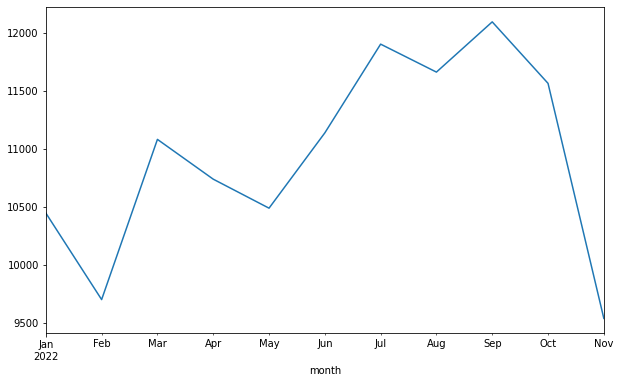

In [112]:
df_crime_sf[df_crime_sf['date'] >= cutoff].groupby('month')['Incident Number'].count().plot()
plt.gcf().set_size_inches(10, 6)
plt.show()

In [113]:
df_crime_sf2 = df_crime_sf[df_crime_sf['date'] >= cutoff].copy()

In [114]:
df_region_sf = df_crime_sf2['Analysis Neighborhood'].value_counts().reset_index().rename(
    columns={'index': 'neighborhood', 'Analysis Neighborhood': 'num_crimes'})
df_region_sf

neighborhood  num_crimes
0                       Tenderloin       12486
1                          Mission       11481
2                  South of Market        9144
3   Financial District/South Beach        8445
4            Bayview Hunters Point        8080
5                      North Beach        4395
6                 Western Addition        3804
7                  Sunset/Parkside        3552
8                           Marina        3417
9                         Nob Hill        3185
10                    Hayes Valley        2990
11             Castro/Upper Market        2949
12                    Russian Hill        2753
13                  Outer Richmond        2680
14              West of Twin Peaks        2319
15                  Bernal Heights        2164
16                       Chinatown        2017
17                     Mission Bay        1901
18                 Pacific Heights        1894
19                    Potrero Hill        1893
20                       Excelsior        1848
21                       Lakeshore        1698
22                  Haight Ashbury        1617
23                   Outer Mission        1568
24                  Inner Richmond        1476
25                       Japantown        1460
26                    Inner Sunset        1394
27                      Noe Valley        1327
28               Lone Mountain/USF        1307
29                         Portola        1284
30      Oceanview/Merced/Ingleside        1280
31                Golden Gate Park        1169
32               Visitacion Valley        1140
33                       Glen Park         670
34                Presidio Heights         657
35                      Twin Peaks         642
36                 Treasure Island         441
37                        Seacliff         187
38                    Lincoln Park         175
39                    McLaren Park         163
40                        Presidio         141

In [115]:
df_pop = pd.read_csv('population_sf.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (866,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,10

In [116]:
df_pop2 = df_pop[df_pop['the_geom'].str.contains('MULTIPOLYGON')].drop_duplicates(subset='NHOOD').dropna(subset=['NHOOD', 'TRACTCE10'])
df_pop2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 197
Columns: 6468 entries, the_geom to Unnamed: 6467
dtypes: float64(4), object(6464)
memory usage: 2.0+ MB


In [117]:
df_pop2['TRACTCE10'].dropna().astype(int).sum()

3948529

In [118]:
df_pop2.head()

the_geom       GEOID  \
0   MULTIPOLYGON (((-122.43246699970955 37.7737570...  6075016400   
1   MULTIPOLYGON (((-122.4235409996432 37.77967400...  6075016100   
3   MULTIPOLYGON (((-122.42468700019211 37.7853350...  6075015500   
4   MULTIPOLYGON (((-122.43491799981281 37.7858759...  6075015300   
10  MULTIPOLYGON (((-122.40840200006795 37.7882929...  6075012100   

               NHOOD TRACTCE10   SHAPE_AREA    SHAPE_LEN Unnamed: 6  \
0       Hayes Valley     16400  3326589.161  7589.679396        NaN   
1   Western Addition     16100  3970258.841  8525.808755        NaN   
3          Japantown     15500  3364564.734  12144.01676        NaN   
4    Pacific Heights     15300  2515362.515  6918.268026        NaN   
10          Nob Hill     12100   1327996.43  5234.011533        NaN   

   Unnamed: 7 Unnamed: 8 Unnamed: 9 Unnamed: 10 Unnamed: 11 Unnamed: 12  \
0         NaN        NaN        NaN         NaN         NaN         NaN   
1         NaN        NaN        NaN         NaN         NaN         NaN   
3         NaN        NaN        NaN         NaN         NaN         NaN   
4         NaN        NaN        NaN         NaN         NaN         NaN   
10        NaN        NaN        NaN         NaN         NaN         NaN   

   Unnamed: 13 Unnamed: 14 Unnamed: 15 Unnamed: 16 Unnamed: 17 Unnamed: 18  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
10         NaN         NaN         NaN         NaN         NaN         NaN   

   Unnamed: 19 Unnamed: 20 Unnamed: 21 Unnamed: 22 Unnamed: 23 Unnamed: 24  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
10         NaN         NaN         NaN         NaN         NaN         NaN   

   Unnamed: 25 Unnamed: 26 Unnamed: 27 Unnamed: 28 Unnamed: 29 Unnamed: 30  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
10         NaN         NaN         NaN         NaN         NaN         NaN   

   Unnamed: 31 Unnamed: 32 Unnamed: 33 Unnamed: 34 Unnamed: 35 Unnamed: 36  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
10         NaN         NaN         NaN         NaN         NaN         NaN   

   Unnamed: 37 Unnamed: 38 Unnamed: 39 Unnamed: 40 Unnamed: 41 Unnamed: 42  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
10         NaN         NaN         NaN         NaN         NaN         NaN   

   Unnamed: 43 Unnamed: 44 Unnamed: 45 Unnamed: 46 Unnamed: 47 Unnamed: 48  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
10         NaN   

In [119]:
population_sf = pd.Series(data=df_pop2['TRACTCE10'].to_numpy(), index=df_pop2['NHOOD']).astype(int)
population_sf
# There are three very high values, probably errors that should be removed

NHOOD
Hayes Valley                       16400
Western Addition                   16100
Japantown                          15500
Pacific Heights                    15300
Nob Hill                           12100
Chinatown                          11300
Marina                             12601
Russian Hill                       10900
Tenderloin                         12502
Bayview Hunters Point              61200
Outer Richmond                     47802
Sunset/Parkside                    32902
Oceanview/Merced/Ingleside         31301
Potrero Hill                       22704
South of Market                    17802
Financial District/South Beach     11700
North Beach                        10600
McLaren Park                      980501
Lincoln Park                      980200
Golden Gate Park                  980300
Lakeshore                          33204
Mission Bay                        60700
Visitacion Valley                  60502
Lone Mountain/USF                  16500
Mission   

In [120]:
# From US census (2010)
population_sf = population_sf[population_sf < 100000]
df_region_sf['population'] = df_region_sf['neighborhood'].map(population_sf)

# Total number of crimes in 2022 per 100,000 people
df_region_sf['crime_rate_100k'] = 100000 * df_region_sf['num_crimes'] / df_region_sf['population']
df_region_sf

# Numbers are unreliable and unrealistic. Wouldn't trust

neighborhood  num_crimes  population  crime_rate_100k
0                       Tenderloin       12486     12502.0     99872.020477
1                          Mission       11481     20700.0     55463.768116
2                  South of Market        9144     17802.0     51365.015167
3   Financial District/South Beach        8445     11700.0     72179.487179
4            Bayview Hunters Point        8080     61200.0     13202.614379
5                      North Beach        4395     10600.0     41462.264151
6                 Western Addition        3804     16100.0     23627.329193
7                  Sunset/Parkside        3552     32902.0     10795.696310
8                           Marina        3417     12601.0     27116.895484
9                         Nob Hill        3185     12100.0     26322.314050
10                    Hayes Valley        2990     16400.0     18231.707317
11             Castro/Upper Market        2949     20300.0     14527.093596
12                    Russian Hill        2753     10900.0     25256.880734
13                  Outer Richmond        2680     47802.0      5606.459981
14              West of Twin Peaks        2319     31100.0      7456.591640
15                  Bernal Heights        2164     25401.0      8519.349632
16                       Chinatown        2017     11300.0     17849.557522
17                     Mission Bay        1901     60700.0      3131.795717
18                 Pacific Heights        1894     15300.0     12379.084967
19                    Potrero Hill        1893     22704.0      8337.737844
20                       Excelsior        1848     26303.0      7025.814546
21                       Lakeshore        1698     33204.0      5113.841706
22                  Haight Ashbury        1617     16600.0      9740.963855
23                   Outer Mission        1568     26200.0      5984.732824
24                  Inner Richmond        1476     45200.0      3265.486726
25                       Japantown        1460     15500.0      9419.354839
26                    Inner Sunset        1394     30302.0      4600.356412
27                      Noe Valley        1327     21400.0      6200.934579
28               Lone Mountain/USF        1307     16500.0      7921.212121
29                         Portola        1284     25900.0      4957.528958
30      Oceanview/Merced/Ingleside        1280     31301.0      4089.326220
31                Golden Gate Park        1169         NaN              NaN
32               Visitacion Valley        1140     60502.0      1884.235232
33                       Glen Park         670     21800.0      3073.394495
34                Presidio Heights         657     15400.0      4266.233766
35                      Twin Peaks         642     30500.0      2104.918033
36                 Treasure Island         441     17902.0      2463.411909
37                        Seacliff         187     42800.0       436.915888
38                    Lincoln Park         175         NaN              NaN
39                    McLaren Park         163         NaN              NaN
40                        Presidio         141     60100.0       234.608985

These crime rates are very high (much higher than the New York rates) and probably the result of some errors. We'll continue our analysis but take the results with a grain of salt.

In [121]:
rsr_region_sf = df_listings_filtered_sf.groupby('neighbourhood_cleansed2')['review_scores_rating'].mean()
print(rsr_region_sf.to_dict())

rsl_region_sf = df_listings_filtered_sf.groupby('neighbourhood_cleansed2')['review_scores_location'].mean()
print(rsl_region_sf.to_dict())

{'Bayview Hunters Point': 4.6974, 'Bernal Heights': 4.851616161616161, 'Castro/Upper Market': 4.8721989528795815, 'Chinatown': 4.767857142857143, 'Crocker Amazon': 4.725384615384615, 'Diamond Heights': 4.84, 'Downtown/Civic Center': 4.600876132930514, 'Excelsior': 4.8275, 'Financial District/South Beach': 4.537857142857143, 'Glen Park': 4.858409090909091, 'Golden Gate Park': 4.83, 'Haight Ashbury': 4.82048275862069, 'Inner Richmond': 4.82425, 'Inner Sunset': 4.844509803921569, 'Lakeshore': 4.832666666666666, 'Marina': 4.775692307692308, 'Mission': 4.825770308123249, 'Nob Hill': 4.765874999999999, 'Noe Valley': 4.890675675675676, 'North Beach': 4.735352112676056, 'Oceanview/Merced/Ingleside': 4.745251798561151, 'Outer Mission': 4.818297872340426, 'Outer Richmond': 4.79688, 'Pacific Heights': 4.77494382022472, 'Potrero Hill': 4.891320754716982, 'Presidio': 4.854, 'Presidio Heights': 4.797083333333333, 'Russian Hill': 4.814268292682927, 'Seacliff': 4.905714285714287, 'South of Market': 4.

In [122]:
df_region_sf['rating_avg'] = df_region_sf['neighborhood'].map(rsr_region_sf.to_dict())
df_region_sf['location_avg'] = df_region_sf['neighborhood'].map(rsl_region_sf.to_dict())
df_region_sf

neighborhood  num_crimes  population  crime_rate_100k  \
0                       Tenderloin       12486     12502.0     99872.020477   
1                          Mission       11481     20700.0     55463.768116   
2                  South of Market        9144     17802.0     51365.015167   
3   Financial District/South Beach        8445     11700.0     72179.487179   
4            Bayview Hunters Point        8080     61200.0     13202.614379   
5                      North Beach        4395     10600.0     41462.264151   
6                 Western Addition        3804     16100.0     23627.329193   
7                  Sunset/Parkside        3552     32902.0     10795.696310   
8                           Marina        3417     12601.0     27116.895484   
9                         Nob Hill        3185     12100.0     26322.314050   
10                    Hayes Valley        2990     16400.0     18231.707317   
11             Castro/Upper Market        2949     20300.0     14527.093596   
12                    Russian Hill        2753     10900.0     25256.880734   
13                  Outer Richmond        2680     47802.0      5606.459981   
14              West of Twin Peaks        2319     31100.0      7456.591640   
15                  Bernal Heights        2164     25401.0      8519.349632   
16                       Chinatown        2017     11300.0     17849.557522   
17                     Mission Bay        1901     60700.0      3131.795717   
18                 Pacific Heights        1894     15300.0     12379.084967   
19                    Potrero Hill        1893     22704.0      8337.737844   
20                       Excelsior        1848     26303.0      7025.814546   
21                       Lakeshore        1698     33204.0      5113.841706   
22                  Haight Ashbury        1617     16600.0      9740.963855   
23                   Outer Mission        1568     26200.0      5984.732824   
24                  Inner Richmond        1476     45200.0      3265.486726   
25                       Japantown        1460     15500.0      9419.354839   
26                    Inner Sunset        1394     30302.0      4600.356412   
27                      Noe Valley        1327     21400.0      6200.934579   
28               Lone Mountain/USF        1307     16500.0      7921.212121   
29                         Portola        1284     25900.0      4957.528958   
30      Oceanview/Merced/Ingleside        1280     31301.0      4089.326220   
31                Golden Gate Park        1169         NaN              NaN   
32               Visitacion Valley        1140     60502.0      1884.235232   
33                       Glen Park         670     21800.0      3073.394495   
34                Presidio Heights         657     15400.0      4266.233766   
35                      Twin Peaks         642     30500.0      2104.918033   
36                 Treasure Island         441     17902.0      2463.411909   
37                        Seacliff         187     42800.0       436.915888   
38                    Lincoln Park         175         NaN              NaN   
39                    McLaren Park         163         NaN              NaN   
40                        Presidio         141     60100.0       234.608985   

    rating_avg  location_avg  
0          NaN           NaN  
1     4.825770      4.791821  
2     4.784823      4.624248  
3     4.537857      4.812857  
4     4.697400      4.316000  
5     4.735352      4.898028  
6     4.854053      4.894205  
7     4.818754      4.810748  
8     4.775692      4.925385  
9     4.765875      4.838500  
10         NaN           NaN  
11    4.872199      4.946492  
12    4.814268      4.932927  
13    4.796880      4.837120  
14    4.864932      4.853151  
15    4.851616      4.811717  
16    4.767857      4.871667  
17         NaN           NaN  
18    4.774944      4.931910  
19    4.891321      4.868396  
20    4.827500      4.677083  
21    4.832667      4

In [123]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

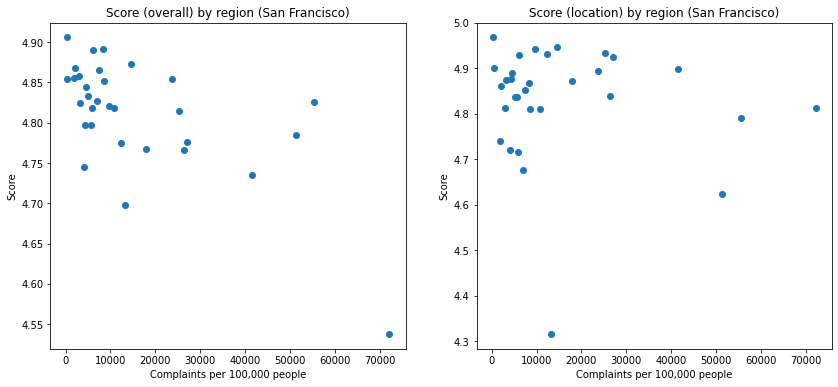

In [124]:
fig, axs = plt.subplots(ncols=2)
labels = df_region_sf['neighborhood'].str.title()

axs[0].scatter(x=df_region_sf['crime_rate_100k'], y=df_region_sf['rating_avg'])
axs[0].set_xlabel('Complaints per 100,000 people')
axs[0].set_ylabel('Score')
axs[0].set_title('Score (overall) by region (San Francisco)')
#label_point(df_region_sf['crime_rate_100k'], df_region_sf['rating_avg'], labels, axs[0])

axs[1].scatter(x=df_region_sf['crime_rate_100k'], y=df_region_sf['location_avg'])
axs[1].set_xlabel('Complaints per 100,000 people')
axs[1].set_ylabel('Score')
axs[1].set_title('Score (location) by region (San Francisco)')
#label_point(df_region_sf['crime_rate_100k'], df_region_sf['location_avg'], labels, axs[1])

fig.set_size_inches(14, 6)
plt.show()

Again, we expect to see a negative correlation between score and crime rate. This is a little easier to see for San Francisco, since we have more regions and therefore points on the scatter plot. There does seem to be some slight negative correlation, but again the scaling may be wrong for the crime rate.

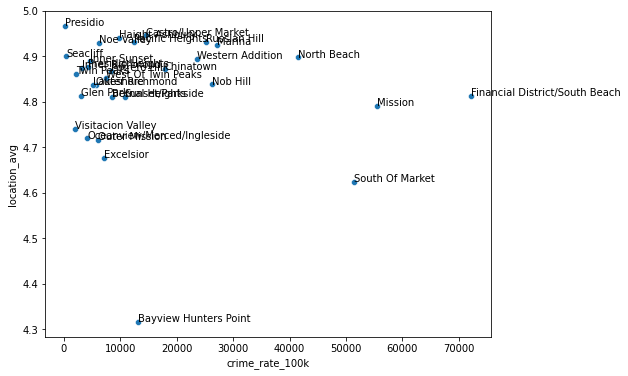

In [125]:
sns.scatterplot(x=df_region_sf['crime_rate_100k'], y=df_region_sf['location_avg'])

labels = df_region_sf['neighborhood'].str.title()
label_point(df_region_sf['crime_rate_100k'], df_region_sf['location_avg'], labels, plt.gca())

plt.gcf().set_size_inches(8, 6)
plt.show()

Like we did before for the New York crime data, let's plot the crime rate over time for each neighborhood (by month).

In [126]:
#df_crime_sf['month'] = df_crime_sf['date'].dt.to_period('M').dt.to_timestamp()
df_region_sf2 = df_crime_sf2.groupby(['Analysis Neighborhood', 'month'])['Incident Number'].count().reset_index().sort_values(by=['Incident Number', 'month'])
df_region_sf2['population'] = df_region_sf2['Analysis Neighborhood'].map(population_sf)
df_region_sf2['crime_rate_100k'] = 100000 * df_region_sf2['Incident Number'] / df_region_sf2['population']
df_region_sf2

Analysis Neighborhood      month  Incident Number  population  \
162          Lincoln Park 2022-09-01                5         NaN   
328              Presidio 2022-10-01                6     60100.0   
323              Presidio 2022-05-01                7     60100.0   
320              Presidio 2022-02-01                9     60100.0   
321              Presidio 2022-03-01                9     60100.0   
..                    ...        ...              ...         ...   
207               Mission 2022-10-01             1136     20700.0   
390            Tenderloin 2022-06-01             1242     12502.0   
393            Tenderloin 2022-09-01             1295     12502.0   
392            Tenderloin 2022-08-01             1328     12502.0   
391            Tenderloin 2022-07-01             1503     12502.0   

     crime_rate_100k  
162              NaN  
328         9.983361  
323        11.647255  
320        14.975042  
321        14.975042  
..               ...  
207      5487.922705  
390      9934.410494  
393     10358.342665  
392     10622.300432  
391     12022.076468  

[451 rows x 5 columns]

In [127]:
crime_table_sf = pd.pivot_table(df_region_sf2, values='crime_rate_100k', index=['Analysis Neighborhood'], columns=['month'], fill_value=0)
crime_table_sf

month                            2022-01-01   2022-02-01   2022-03-01  \
Analysis Neighborhood                                                   
Bayview Hunters Point           1104.575163  1093.137255  1142.156863   
Bernal Heights                   570.843668   704.696665   732.254636   
Castro/Upper Market             1694.581281  1403.940887  1428.571429   
Chinatown                       1247.787611  1389.380531  1681.415929   
Excelsior                        638.710413   513.249439   676.728890   
Financial District/South Beach  6008.547009  6418.803419  6948.717949   
Glen Park                        270.642202   233.944954   330.275229   
Haight Ashbury                   837.349398   789.156627   686.746988   
Hayes Valley                    1518.292683  1298.780488  1542.682927   
Inner Richmond                   280.973451   307.522124   316.371681   
Inner Sunset                     455.415484   379.512903   438.914923   
Japantown                        948.387097   774.193548  1064.516129   
Lakeshore                        557.161788   545.115046   527.044934   
Lone Mountain/USF                624.242424   648.484848   775.757576   
Marina                          2436.314578  2555.352750  2777.557337   
Mission                         4917.874396  4376.811594  4961.352657   
Mission Bay                      278.418451   313.014827   289.950577   
Nob Hill                        2512.396694  2115.702479  2479.338843   
Noe Valley                       691.588785   462.616822   495.327103   
North Beach                     3084.905660  3264.150943  3679.245283   
Oceanview/Merced/Ingleside       434.490911   383.374333   380.179547   
Outer Mission                    511.450382   419.847328   541.984733   
Outer Richmond                   502.071043   416.300573   546.002259   
Pacific Heights                 1267.973856  1176.470588  1124.183007   
Portola                          482.625483   436.293436   347.490347   
Potrero Hill                     814.834390   594.608879   770.789288   
Presidio                          16.638935    14.975042    14.975042   
Presidio Heights                 324.675325   318.181818   428.571429   
Russian Hill                    2201.834862  1779.816514  2697.247706   
Seacliff                          39.719626    42.056075    25.700935   
South of Market                 4066.958769  3926.525110  4684.866869   
Sunset/Parkside                  978.663911   841.894110   954.349280   
Tenderloin                      8294.672852  6662.933931  8678.611422   
Treasure Island                  212.266786   273.712434   296.056307   
Twin Peaks                       245.901639   111.475410   134.426230   
Visitacion Valley                143.796899   117.351493   147.102575   
West of Twin Peaks               604.501608   665.594855   765.273312   
Western Addition                1919.254658  2068.322981  2204.968944   

month                            2022-04-01   2022-05-01   2022-06-01  \
Analysis Neighborhood                                                   
Bayview Hunters Point           1148.692810  1297.385621  1181.372549   
Bernal Heights                   846.423369   673.201842   681.075548   
Castro/Upper Market             1448.275862  1182.266010  1374.384236   
Chinatown                       1433.628319  1743.362832  2044.247788   
Excelsior                        494.240201   619.701175   615.899327   
Financial District/South Beach  6641.025641  6282.051282  7230.769231   
Glen Park                        266.055046   206.422018   211.009174   
Haight Ashbury                   897.590361   891.566265   753.012048   
Hayes Valley                    1426.829268  1475.609756  1774.390244   
Inner Richmond                   325.221239   323.008850   274.336283   
Inner Sunset                     514.817504   386.113128   432.314699   
Japantown                        651.612903   703.225806   851.612903   
Lakeshore                        487.893025   478.857969 

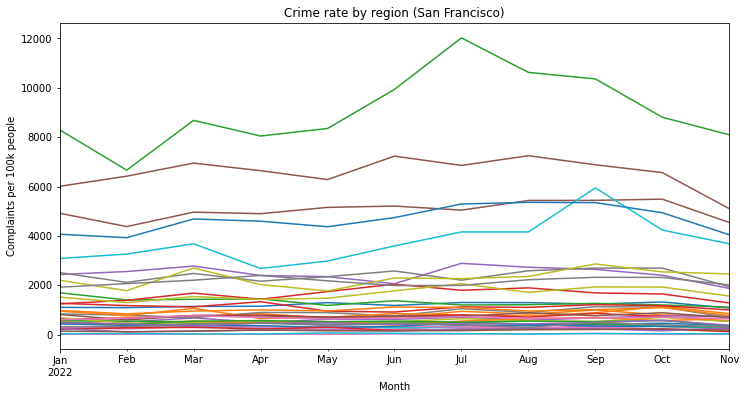

In [128]:
for row in crime_table_sf.T:
  crime_table_sf.loc[row].plot(label=row.title())

#plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Complaints per 100k people')
plt.xlabel('Month')
plt.title('Crime rate by region (San Francisco)')
plt.gcf().set_size_inches(12, 6)
plt.show()

# A high monthly crime rate should be ~500 per 100k. Clearly some series are erroneous

### Ratings vs. home value index (ZHVI)

In [129]:
df_home_sf = df_home[df_home['City'] == 'San Francisco']
df_home_sf

RegionID  SizeRank          RegionName    RegionType StateName State  \
173      268384       183        Outer Sunset  neighborhood        CA    CA   
267      274552       282             Mission  neighborhood        CA    CA   
392      268383       415      Outer Richmond  neighborhood        CA    CA   
403      268491       426     South of Market  neighborhood        CA    CA   
483      268219       507      Inner Richmond  neighborhood        CA    CA   
...         ...       ...                 ...           ...       ...   ...   
13675    417508     16011      Balboa Terrace  neighborhood        CA    CA   
14271     35760     16753            Presidio  neighborhood        CA    CA   
14840    417512     17478    Monterey Heights  neighborhood        CA    CA   
16150    786297     19125    Showplace Square  neighborhood        CA    CA   
17182    417513     20416  Westwood Highlands  neighborhood        CA    CA   

                City                               Metro  \
173    San Francisco  San Francisco-Oakland-Berkeley, CA   
267    San Francisco  San Francisco-Oakland-Berkeley, CA   
392    San Francisco  San Francisco-Oakland-Berkeley, CA   
403    San Francisco  San Francisco-Oakland-Berkeley, CA   
483    San Francisco  San Francisco-Oakland-Berkeley, CA   
...              ...                                 ...   
13675  San Francisco  San Francisco-Oakland-Berkeley, CA   
14271  San Francisco  San Francisco-Oakland-Berkeley, CA   
14840  San Francisco  San Francisco-Oakland-Berkeley, CA   
16150  San Francisco  San Francisco-Oakland-Berkeley, CA   
17182  San Francisco  San Francisco-Oakland-Berkeley, CA   

                 CountyName  2000-01-31  2000-02-29  2000-03-31  2000-04-30  \
173    San Francisco County    415151.0    417923.0    421150.0    428433.0   
267    San Francisco County    405390.0    406316.0    412735.0    425509.0   
392    San Francisco County    551075.0    553189.0    556481.0    564454.0   
403    San Francisco County    427595.0    431008.0    436386.0    446121.0   
483    San Francisco County    620447.0    625726.0    630496.0    640590.0   
...                     ...         ...         ...         ...         ...   
13675  San Francisco County    787037.0    789352.0    795113.0    808261.0   
14271  San Francisco County         NaN         NaN         NaN         NaN   
14840  San Francisco County    932057.0    938741.0    944021.0    958339.0   
16150  San Francisco County         NaN         NaN         NaN         NaN   
17182  San Francisco County    627851.0    636362.0    640641.0    652725.0   

       2000-05-31  2000-06-30  2000-07-31  2000-08-31  2000-09-30  2000-10-31  \
173      435952.0    444721.0    453293.0    462626.0    470803.0    479436.0   
267      441064.0    453913.0    464209.0    476404.0    489533.0    503491.0   
392      572476.0    583121.0    593425.0    605094.0    613575.0    621657.0   
403      455894.0    464952.0    474293.0    485259.0    497513.0    509923.0   
483      651381.0    664330.0    677545.0    688823.0    697648.0    707615.0   
...           ...         ...         ...         ...         ...         ...   
13675    823959.0    836115.0    844480.0    858863.0    872289.0    886385.0   
14271         NaN         NaN         NaN         NaN         NaN         NaN   
14840    975493.0    991975.0   1010563.0   1025310.0   1039867.0   1051999.0   
16150         NaN         NaN         NaN         NaN         NaN         NaN   
17182    659179.0    666878.0    673964.0    683666.0    694643.0    703660.0   

       2000-11-30  2000-12-31  2001-01-31  2001-02-28  2001-03-31  2001-04-30  \
173      488208.0    499067.0    510254.0    521085.0    528164.0    534246.0   
267      516708.0    527812.0    538127.0    546803.0    554078.0    559120.0   
392      631526.0    643929.0    656815.0    668089.0    676091.0    683970.0   
403      522345.0    534243.0    546117.0    556159.0    561125.0    564496.0   
483      7

In [130]:
l1 = df_listings_sf['neighbourhood_cleansed'].unique()
l2 = df_home_sf['RegionName'].unique()

print(len(l1))
print(len(l2))
print(len(list(set(l1).intersection(l2))))

36
108
29


In [131]:
print(df_home_sf['RegionName'].value_counts()) # ensure no duplicates

Outer Sunset          1
Bret Harte            1
Ingleside Terrace     1
Downtown              1
Lake                  1
                     ..
Dolores Heights       1
Glen Park             1
North Beach           1
Silver Terrace        1
Westwood Highlands    1
Name: RegionName, Length: 108, dtype: int64


In [132]:
df_home_sf = df_home_sf.set_index('RegionName')

# Filter to relevant (or potentially relevant) columns
df_listings_sf2 = df_listings_sf[['id', 'neighbourhood_cleansed2', 'price', 'review_scores_rating', 'review_scores_location', 'date']].copy()
df_listings_sf2 = df_listings_sf2.dropna(subset=['review_scores_location'])
df_listings_sf2['price'] = df_listings_sf2['price'].apply(lambda s: re.sub('[$,]', '', s)).astype(float)
df_listings_sf2['month_end'] = (df_listings_sf2['date'].dt.to_period('M').dt.to_timestamp() 
  + pd.offsets.MonthEnd(0)).dt.strftime('%Y-%m-%d')

df_listings_sf2

id     neighbourhood_cleansed2  price  review_scores_rating  \
0          958            Western Addition  180.0                  4.86   
1         5858              Bernal Heights  235.0                  4.88   
2         8014               Outer Mission   61.0                  4.75   
3       148627                      Marina   85.0                  4.29   
4       494111              Outer Richmond  146.0                  4.65   
...        ...                         ...    ...                   ...   
6624  27232655  Oceanview/Merced/Ingleside  108.0                  4.66   
6625  13926812              Crocker Amazon   47.0                  4.95   
6626  29311755  Oceanview/Merced/Ingleside  191.0                  4.93   
6627  13935443              Crocker Amazon   65.0                  4.96   
6628  34681471              Crocker Amazon  138.0                  4.94   

      review_scores_location       date   month_end  
0                       4.98 2022-08-21  2022-08-31  
1                       4.77 2017-08-06  2017-08-31  
2                       4.59 2022-09-04  2022-09-30  
3                       4.63 2022-08-06  2022-08-31  
4                       4.66 2022-08-23  2022-08-31  
...                      ...        ...         ...  
6624                    4.60 2021-09-26  2021-09-30  
6625                    4.70 2022-08-20  2022-08-31  
6626                    4.70 2022-08-20  2022-08-31  
6627                    4.76 2022-09-06  2022-09-30  
6628                    4.78 2021-08-01  2021-08-31  

[5499 rows x 7 columns]

In [133]:
# Filter to compatible neighborhoods
df_listings_sf3 = df_listings_sf2[df_listings_sf2['neighbourhood_cleansed2'].isin(df_home_sf.index)].copy()
df_listings_sf3

id neighbourhood_cleansed2  price  review_scores_rating  \
0                    958        Western Addition  180.0                  4.86   
1                   5858          Bernal Heights  235.0                  4.88   
2                   8014           Outer Mission   61.0                  4.75   
3                 148627                  Marina   85.0                  4.29   
4                 494111          Outer Richmond  146.0                  4.65   
...                  ...                     ...    ...                   ...   
6622  686361877890940845               Lakeshore  104.0                  5.00   
6623            21372487               Lakeshore   92.0                  4.89   
6625            13926812          Crocker Amazon   47.0                  4.95   
6627            13935443          Crocker Amazon   65.0                  4.96   
6628            34681471          Crocker Amazon  138.0                  4.94   

      review_scores_location       date   month_end  
0                       4.98 2022-08-21  2022-08-31  
1                       4.77 2017-08-06  2017-08-31  
2                       4.59 2022-09-04  2022-09-30  
3                       4.63 2022-08-06  2022-08-31  
4                       4.66 2022-08-23  2022-08-31  
...                      ...        ...         ...  
6622                    5.00 2022-08-21  2022-08-31  
6623                    4.82 2022-08-20  2022-08-31  
6625                    4.70 2022-08-20  2022-08-31  
6627                    4.76 2022-09-06  2022-09-30  
6628                    4.78 2021-08-01  2021-08-31  

[3534 rows x 7 columns]

In [134]:
# Get home value index for particular neighborhood and month
df_listings_sf3['zhvi'] = df_listings_sf3.apply(lambda x: df_home_sf.loc[x['neighbourhood_cleansed2']][x['month_end']], axis=1)

In [135]:
df_listings_sf3 = df_listings_sf3.dropna(subset=['zhvi'])
df_listings_sf3

id neighbourhood_cleansed2  price  review_scores_rating  \
0                    958        Western Addition  180.0                  4.86   
1                   5858          Bernal Heights  235.0                  4.88   
2                   8014           Outer Mission   61.0                  4.75   
3                 148627                  Marina   85.0                  4.29   
4                 494111          Outer Richmond  146.0                  4.65   
...                  ...                     ...    ...                   ...   
6622  686361877890940845               Lakeshore  104.0                  5.00   
6623            21372487               Lakeshore   92.0                  4.89   
6625            13926812          Crocker Amazon   47.0                  4.95   
6627            13935443          Crocker Amazon   65.0                  4.96   
6628            34681471          Crocker Amazon  138.0                  4.94   

      review_scores_location       date   month_end       zhvi  
0                       4.98 2022-08-21  2022-08-31  1295462.0  
1                       4.77 2017-08-06  2017-08-31  1359263.0  
2                       4.59 2022-09-04  2022-09-30  1179953.0  
3                       4.63 2022-08-06  2022-08-31  2360098.0  
4                       4.66 2022-08-23  2022-08-31  1799786.0  
...                      ...        ...         ...        ...  
6622                    5.00 2022-08-21  2022-08-31  1657001.0  
6623                    4.82 2022-08-20  2022-08-31  1657001.0  
6625                    4.70 2022-08-20  2022-08-31  1279331.0  
6627                    4.76 2022-09-06  2022-09-30  1256782.0  
6628                    4.78 2021-08-01  2021-08-31  1240806.0  

[3534 rows x 8 columns]

In [136]:
df_listings_sf3['date'].describe()

<ipython-input-136-2dd3e100ee1b>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_listings_sf3['date'].describe()


count                    3534
unique                    780
top       2022-09-05 00:00:00
freq                      113
first     2011-09-30 00:00:00
last      2022-09-06 00:00:00
Name: date, dtype: object

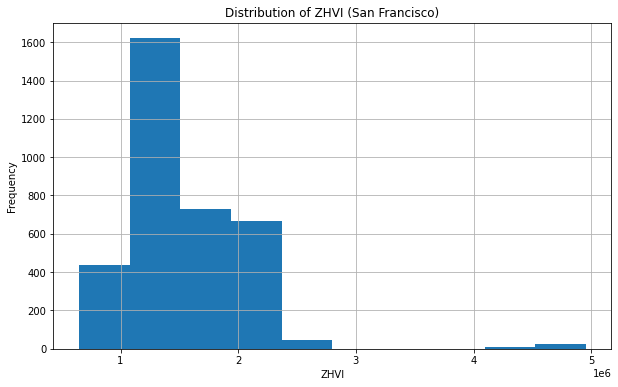

In [137]:
df_listings_sf3['zhvi'].hist()
plt.xlabel('ZHVI')
plt.ylabel('Frequency')
plt.title('Distribution of ZHVI (San Francisco)')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [138]:
def regress(x, y):
  return sm.OLS(y, sm.add_constant(x)).fit().summary()

In [139]:
regress(df_listings_sf3['price'], df_listings_sf3['review_scores_rating'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     6.935
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):            0.00849
Time:                          04:29:08   Log-Likelihood:                -1455.6
No. Observations:                  3534   AIC:                             2915.
Df Residuals:                      3532   BIC:                             2928.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7833      0.007    692.762      0.000       4.770       4.797
price       3.365e-05   1.28e-05      2.633      0.008     8.6e-06    5.87e-05
==============================================================================
Omnibus:                     3536.406   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           210671.830
Skew:                          -4.876   Prob(JB):                         0.00
Kurtosis:                      39.546   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
regress(df_listings_sf3['zhvi'], df_listings_sf3['review_scores_location'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     review_scores_location   R-squared:                       0.034
Model:                                OLS   Adj. R-squared:                  0.034
Method:                     Least Squares   F-statistic:                     124.5
Date:                    Sat, 03 Dec 2022   Prob (F-statistic):           1.92e-28
Time:                            04:29:08   Log-Likelihood:                -1002.8
No. Observations:                    3534   AIC:                             2010.
Df Residuals:                        3532   BIC:                             2022.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6229      0.018    260.791      0.000       4.588       4.658
zhvi        1.205e-07   1.08e-08     11.159      0.000    9.93e-08    1.42e-07
==============================================================================
Omnibus:                     3686.524   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           287612.333
Skew:                          -5.118   Prob(JB):                         0.00
Kurtosis:                      45.994   Cond. No.                     5.38e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

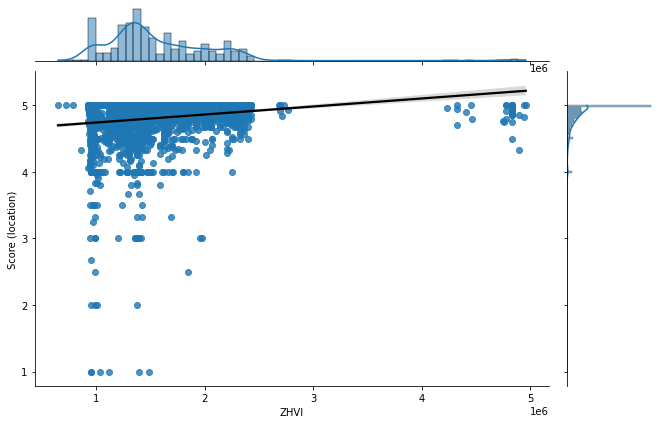

In [141]:
ax = sns.jointplot(x=df_listings_sf3['zhvi'], y=df_listings_sf3['review_scores_location'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
ax.set_axis_labels('ZHVI', 'Score (location)')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [142]:
regress(df_listings_sf3['zhvi'], df_listings_sf3['price'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4641
Date:                Sat, 03 Dec 2022   Prob (F-statistic):              0.496
Time:                        04:29:09   Log-Likelihood:                -26840.
No. Observations:                3534   AIC:                         5.368e+04
Df Residuals:                    3532   BIC:                         5.370e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        228.9630     26.533      8.629      0.000     176.941     280.985
zhvi        1.101e-05   1.62e-05      0.681      0.496   -2.07e-05    4.27e-05
==============================================================================
Omnibus:                     7030.619   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15173004.919
Skew:                          16.007   Prob(JB):                         0.00
Kurtosis:                     322.402   Cond. No.                     5.38e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

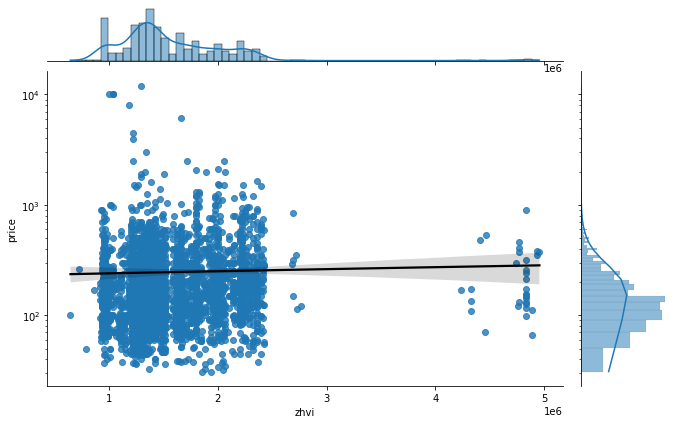

In [143]:
sns.jointplot(x=df_listings_sf3['zhvi'], y=df_listings_sf3['price'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.yscale('log')
plt.show()

We see a lot of similar trends in the San Francisco data, such as positive correlations of scores with price and home value (ZHVI).

### Ratings vs. hotel index

In [144]:
df_hotel2 = df_hotel.set_index('City')
sf_hotel = df_hotel2.loc['San Francisco'].apply(lambda s: re.sub('[$,]', '', s)).astype(float)
sf_hotel

Oct-21    213.0
Nov-21    189.0
Dec-21    194.0
Jan-22    211.0
Feb-22    204.0
Mar-22    215.0
Apr-22    236.0
May-22    261.0
Jun-22    283.0
Jul-22    271.0
Aug-22    284.0
Sep-22    285.0
Oct-22    270.0
Name: San Francisco, dtype: float64

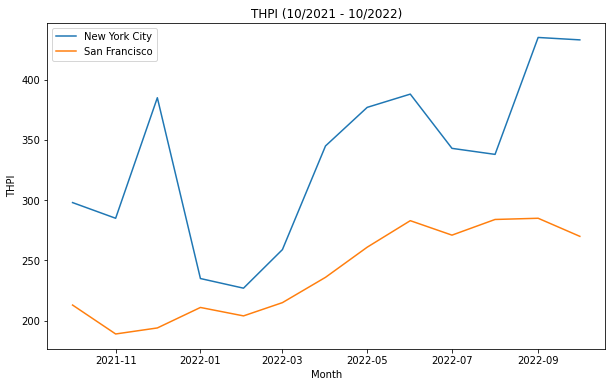

In [145]:
# Compare New York THPI with San Francisco THPI
dates = pd.to_datetime(nyc_hotel.index, format='%b-%y')
plt.plot(dates, nyc_hotel, label='New York City')
plt.plot(dates, sf_hotel, label='San Francisco')
plt.legend()
plt.gcf().set_size_inches(10, 6)
plt.xlabel('Month')
plt.ylabel('THPI')
plt.title('THPI (10/2021 - 10/2022)')
plt.show()

# New York is more expensive, which makes sense

In [146]:
cutoff = pd.to_datetime('10/01/2021')
df_listings_sf4 = df_listings_sf[df_listings_sf['date'] >= cutoff].copy()

In [147]:
pd.to_datetime(sf_hotel.index, format='%b-%y').strftime('%m-%y')

Index(['10-21', '11-21', '12-21', '01-22', '02-22', '03-22', '04-22', '05-22',
       '06-22', '07-22', '08-22', '09-22', '10-22'],
      dtype='object')

In [148]:
df_listings_sf4['month'] = pd.to_datetime(df_listings_sf4['date']).dt.strftime('%b-%y')
df_listings_sf4['hotel_index'] = df_listings_sf4['month'].map(sf_hotel.to_dict())
df_listings_sf4['price'] = df_listings_sf4['price'].apply(lambda s: re.sub('[$,]', '', s)).astype(float)
df_listings_sf4

id                                      listing_url  \
0                    958                 https://www.airbnb.com/rooms/958   
2                   8014                https://www.airbnb.com/rooms/8014   
3                 148627              https://www.airbnb.com/rooms/148627   
4                 494111              https://www.airbnb.com/rooms/494111   
6                 148769              https://www.airbnb.com/rooms/148769   
...                  ...                                              ...   
6622  686361877890940845  https://www.airbnb.com/rooms/686361877890940845   
6623            21372487            https://www.airbnb.com/rooms/21372487   
6625            13926812            https://www.airbnb.com/rooms/13926812   
6626            29311755            https://www.airbnb.com/rooms/29311755   
6627            13935443            https://www.airbnb.com/rooms/13935443   

           scrape_id last_scraped           source  \
0     20220907064650   2022-09-07      city scrape   
2     20220907064650   2022-09-07  previous scrape   
3     20220907064650   2022-09-07      city scrape   
4     20220907064650   2022-09-07      city scrape   
6     20220907064650   2022-09-07      city scrape   
...              ...          ...              ...   
6622  20220907064650   2022-09-07      city scrape   
6623  20220907064650   2022-09-07      city scrape   
6625  20220907064650   2022-09-07  previous scrape   
6626  20220907064650   2022-09-07  previous scrape   
6627  20220907064650   2022-09-07      city scrape   

                                                  name  \
0                Bright, Modern Garden Unit - 1BR/1BTH   
2              room in FEMALE house WIFI market nearby   
3                        Romantic Marina Garden Studio   
4                  Comfortable space of your own in SF   
6              Ground Floor Studio with Garage Parking   
...                                                ...   
6622              Lovely Private Studio with Full Bath   
6623  Comfortable home w/ washer/dryer near SF airport   
6625          (Garden) Private room_few blocks from SF   
6626                     Daly City-Monthly Rental Only   
6627   ( Bay) Private Suite W/ bath_few blocks from SF   

                                            description  \
0     Please check local laws re Covid before you re...   
2     Room is on the second floor so it gets a good ...   
3     Street parking only, please follow all signs.<...   
4     <b>The space</b><br />A beautiful, bright, and...   
6     Located only 7 minutes from UCSF, this is the ...   
...                                                 ...   
6622  My family has been living here for more than 1...   
6623  Nothing fancy but a comfortable and affordable...   
6625  We are couple blocks from SF, enjoy in quiet a...   
6626  Located in the delightfully foggy hills of Dal...   
6627  We are couple blocks from SF, enjoy in quiet a...   

                                  neighborhood_overview  \
0     Quiet cul de sac in friendly neighborhood<br /...   
2     The neighborhood is very residential, close to...   
3     Super convenient walking access to all the bes...   
4     The location is not considered a traditionally...   
6     If you are interested in exploring the neighbo...   
...                                                 ...   
6622                                                NaN   
6623  10 minutes walk to Lake Merced Golf Club. 15 m...   
6625  Walking distance to Walgreens, mini markets, r...   
6626  A quiet residential neighborhood. It is overcr...   
6627  Walking distance to Walgreens, mini markets, r...   

                                            picture_url    host_id  \
0     https://a0.muscache.com/pictures/b7c2a199-4c17...       1169   
2     https://a0.muscache.com/pictures/2cc1fc3d-0ae0...      22402   
3     https://a0.muscache.com/pictures/3048720/ef73f...     709325   
4     https://a0.muscache.com/pictures/a4c0e7ec-caa1.

In [149]:
regress(df_listings_sf4['hotel_index'], df_listings_sf4['price'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.774
Date:                Sat, 03 Dec 2022   Prob (F-statistic):              0.183
Time:                        04:29:12   Log-Likelihood:                -32884.
No. Observations:                4320   AIC:                         6.577e+04
Df Residuals:                    4318   BIC:                         6.578e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         116.7307     82.047      1.423      0.155     -44.124     277.585
hotel_index     0.4008      0.301      1.332      0.183      -0.189       0.991
==============================================================================
Omnibus:                    11984.060   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        470312676.515
Skew:                          34.944   Prob(JB):                         0.00
Kurtosis:                    1617.919   Cond. No.                     3.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

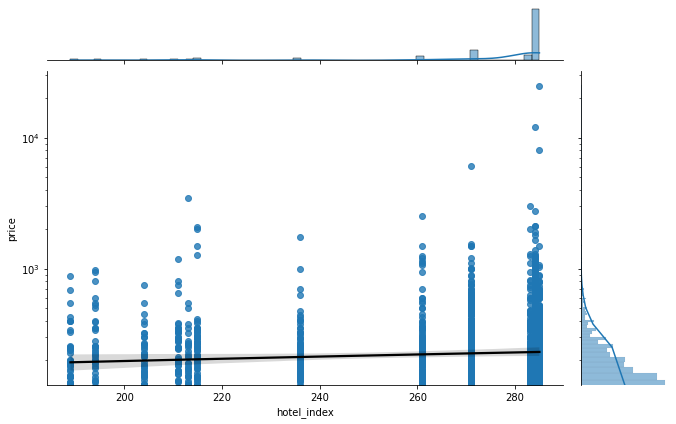

In [150]:
sns.jointplot(x=df_listings_sf4['hotel_index'], y=df_listings_sf4['price'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.yscale('log')
plt.show()

# Hard to use hotel index data since it is based on the entire city of New York
# So we cannot separate into boroughs, neighborhoods, etc.

In [151]:
regress(df_listings_sf4['hotel_index'], df_listings_sf4['review_scores_rating'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.010
Model:                              OLS   Adj. R-squared:                  0.010
Method:                   Least Squares   F-statistic:                     42.80
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):           6.79e-11
Time:                          04:29:17   Log-Likelihood:                -1248.4
No. Observations:                  4320   AIC:                             2501.
Df Residuals:                      4318   BIC:                             2513.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.4387      0.054     81.951      0.000       4.333       4.545
hotel_index     0.0013      0.000      6.542      0.000       0.001       0.002
==============================================================================
Omnibus:                     3929.900   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           195357.116
Skew:                          -4.232   Prob(JB):                         0.00
Kurtosis:                      34.838   Cond. No.                     3.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

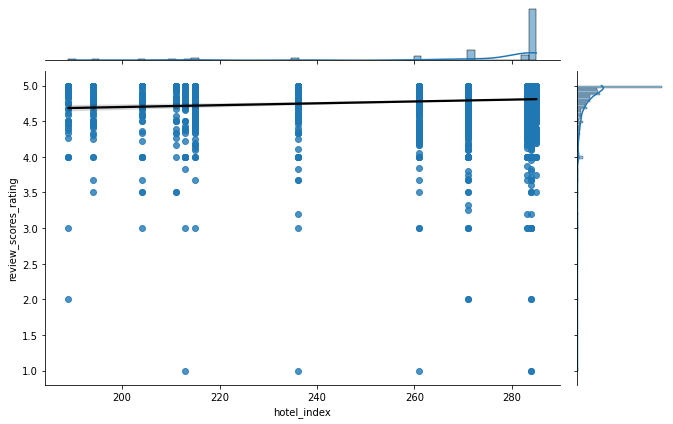

In [152]:
sns.jointplot(x=df_listings_sf4['hotel_index'], y=df_listings_sf4['review_scores_rating'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.show()

### Joint analysis

In [153]:
# Merge data from previous sections
cutoff = pd.to_datetime('01/01/2022')
df_total_sf = df_listings_sf3.merge(df_listings_sf4[['id', 'hotel_index']], on='id')
df_total_sf = df_total_sf[df_total_sf['date'] >= cutoff]
df_total_sf['month_start'] = df_total_sf['date'].dt.to_period('M').dt.to_timestamp()
df_total_sf = df_total_sf[df_total_sf['neighbourhood_cleansed2'].isin(crime_table_sf.index)]
df_total_sf['crime_rate_100k'] = df_total_sf.apply(lambda x: crime_table_sf.loc[x['neighbourhood_cleansed2']][x['month_start']], axis=1)
df_total_sf

id neighbourhood_cleansed2  price  review_scores_rating  \
0                    958        Western Addition  180.0                  4.86   
1                   8014           Outer Mission   61.0                  4.75   
2                 148627                  Marina   85.0                  4.29   
3                 494111          Outer Richmond  146.0                  4.65   
4                 150347                 Mission  149.0                  4.73   
...                  ...                     ...    ...                   ...   
2851            37365235               Lakeshore  112.0                  4.90   
2852            15658593               Lakeshore  106.0                  4.59   
2853  588425052210854500               Lakeshore  145.0                  4.87   
2854  686361877890940845               Lakeshore  104.0                  5.00   
2855            21372487               Lakeshore   92.0                  4.89   

      review_scores_location       date   month_end       zhvi  hotel_index  \
0                       4.98 2022-08-21  2022-08-31  1295462.0        284.0   
1                       4.59 2022-09-04  2022-09-30  1179953.0        285.0   
2                       4.63 2022-08-06  2022-08-31  2360098.0        284.0   
3                       4.66 2022-08-23  2022-08-31  1799786.0        284.0   
4                       4.36 2022-06-11  2022-06-30  1412608.0        283.0   
...                      ...        ...         ...        ...          ...   
2851                    4.90 2022-08-29  2022-08-31  1657001.0        284.0   
2852                    4.74 2022-09-03  2022-09-30  1618745.0        285.0   
2853                    4.93 2022-08-26  2022-08-31  1657001.0        284.0   
2854                    5.00 2022-08-21  2022-08-31  1657001.0        284.0   
2855                    4.82 2022-08-20  2022-08-31  1657001.0        284.0   

     month_start  crime_rate_100k  
0     2022-08-01      2223.602484  
1     2022-09-01       694.656489  
2     2022-08-01      2729.942068  
3     2022-08-01       543.910297  
4     2022-06-01      5207.729469  
...          ...              ...  
2851  2022-08-01       427.659318  
2852  2022-09-01       439.706060  
2853  2022-08-01       427.659318  
2854  2022-08-01       427.659318  
2855  2022-08-01       427.659318  

[2656 rows x 11 columns]

In [154]:
df_total_sf['date'].describe()

<ipython-input-154-bd95eabe0fb1>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_total_sf['date'].describe()


count                    2656
unique                    225
top       2022-09-05 00:00:00
freq                      110
first     2022-01-01 00:00:00
last      2022-09-06 00:00:00
Name: date, dtype: object

In [155]:
regress(df_total_sf['zhvi'], df_total_sf['hotel_index'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hotel_index   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.067
Date:                Sat, 03 Dec 2022   Prob (F-statistic):              0.302
Time:                        04:29:19   Log-Likelihood:                -11652.
No. Observations:                2656   AIC:                         2.331e+04
Df Residuals:                    2654   BIC:                         2.332e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        273.4000      1.207    226.599      0.000     271.034     275.766
zhvi        7.363e-07   7.13e-07      1.033      0.302   -6.62e-07    2.13e-06
==============================================================================
Omnibus:                     1244.204   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5050.453
Skew:                          -2.378   Prob(JB):                         0.00
Kurtosis:                       7.798   Cond. No.                     5.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

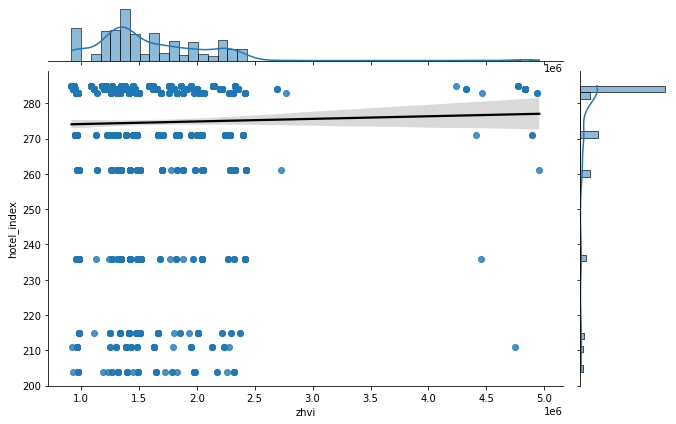

In [156]:
sns.jointplot(x=df_total_sf['zhvi'], y=df_total_sf['hotel_index'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.show()

In [157]:
regress(df_total_sf['crime_rate_100k'], df_total_sf['zhvi']) # caution: crime rates are likely erroneous

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   zhvi   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     626.4
Date:                Sat, 03 Dec 2022   Prob (F-statistic):          2.68e-124
Time:                        04:29:20   Log-Likelihood:                -38494.
No. Observations:                2656   AIC:                         7.699e+04
Df Residuals:                    2654   BIC:                         7.700e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.874e+06   1.41e+04    132.815      0.000    1.85e+06     1.9e+06
crime_rate_100k  -124.8351      4.988    -25.028      0.000    -134.615    -115.055
==============================================================================
Omnibus:                     1650.494   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25768.971
Skew:                           2.679   Prob(JB):                         0.00
Kurtosis:                      17.288   Cond. No.                     4.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

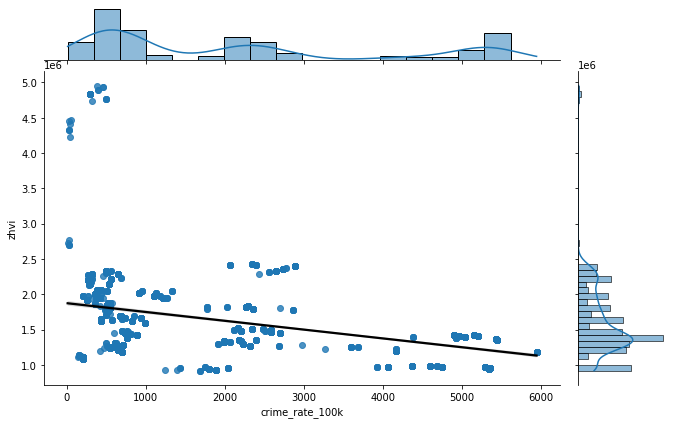

In [158]:
sns.jointplot(x=df_total_sf['crime_rate_100k'], y=df_total_sf['zhvi'], kind='reg', joint_kws={'line_kws': {'color': 'k'}})
plt.gcf().set_size_inches(10, 6)
plt.show()

In [159]:
regress(df_total_sf[['price', 'zhvi', 'hotel_index', 'crime_rate_100k']], df_total_sf['review_scores_rating'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.017
Model:                              OLS   Adj. R-squared:                  0.015
Method:                   Least Squares   F-statistic:                     11.12
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):           6.05e-09
Time:                          04:29:21   Log-Likelihood:                -258.47
No. Observations:                  2656   AIC:                             526.9
Df Residuals:                      2651   BIC:                             556.4
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.5604      0.077     59.446      0.000       4.410       4.711
price            6.353e-05   1.41e-05      4.499      0.000    3.58e-05    9.12e-05
zhvi            -9.196e-09   1.09e-08     -0.845      0.398   -3.05e-08    1.21e-08
hotel_index         0.0010      0.000      3.835      0.000       0.000       0.002
crime_rate_100k -8.852e-06   3.11e-06     -2.847      0.004   -1.49e-05   -2.75e-06
==============================================================================
Omnibus:                     2272.769   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95871.629
Skew:                          -3.848   Prob(JB):                         0.00
Kurtosis:                      31.409   Cond. No.                     2.51e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression results here are similar to those from the overall score model for New York - most predictors except crime rate have positive correlations. The only difference is that ZHVI is no longer a significant predictor. This may indicate collinearity in the data - perhaps the variation was already explained by price or hotel index.

In [160]:
regress(df_total_sf[['price', 'zhvi', 'hotel_index', 'crime_rate_100k']], df_total_sf['review_scores_location'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     review_scores_location   R-squared:                       0.047
Model:                                OLS   Adj. R-squared:                  0.046
Method:                     Least Squares   F-statistic:                     32.69
Date:                    Sat, 03 Dec 2022   Prob (F-statistic):           1.22e-26
Time:                            04:29:21   Log-Likelihood:                -161.78
No. Observations:                    2656   AIC:                             333.6
Df Residuals:                        2651   BIC:                             363.0
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.7034      0.074     63.583      0.000       4.558       4.848
price            6.077e-05   1.36e-05      4.463      0.000    3.41e-05    8.75e-05
zhvi             8.249e-08   1.05e-08      7.859      0.000    6.19e-08    1.03e-07
hotel_index     -2.616e-05      0.000     -0.102      0.919      -0.001       0.000
crime_rate_100k -7.793e-06      3e-06     -2.599      0.009   -1.37e-05   -1.91e-06
==============================================================================
Omnibus:                     2262.231   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            82440.343
Skew:                          -3.881   Prob(JB):                         0.00
Kurtosis:                      29.167   Cond. No.                     2.51e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see something similar here - most predictors (except crime rate) have positive correlations, while hotel index is not a significant predictor this time. Again, this may be due to collinearity in the data.

# Combined model

Now, let's gather all the predictors we have used so far into a combined regression model. This involves cleaning and merging all the datasets we have created so far.

Actually, there are a total of four combined regression models, since we have two cities and two dependent variables.

In [161]:
cleaned_df['host_location'].dropna().value_counts()

New York, NY         6622
Los Angeles, CA      5660
San Diego, CA        4698
Nashville, TN        3473
San Francisco, CA    3325
                     ... 
Buffalo, NY             1
Gresham, OR             1
St. Charles, IL         1
Kekaha, HI              1
Trumbull, CT            1
Name: host_location, Length: 1188, dtype: int64

In [162]:
df_ny = cleaned_df[cleaned_df['host_location'] == 'New York, NY']
df_sf = cleaned_df[cleaned_df['host_location'] == 'San Francisco, CA']

In [163]:
df_ny = df_ny.merge(df_total, left_on='listing_id', right_on='id', suffixes=(None, '_x')).drop_duplicates()
df_ny = df_ny.drop(columns=[c for c in df_ny.columns if '_x' in c])

df_sf = df_sf.merge(df_total_sf, left_on='listing_id', right_on='id', suffixes=(None, '_x')).drop_duplicates()
df_sf = df_sf.drop(columns=[c for c in df_ny.columns if '_x' in c])

In [164]:
df_ny

listing_id host_location host_response_time  host_response_rate  \
0     39627727.0  New York, NY     within an hour            0.990001   
25    48621914.0  New York, NY     within an hour            0.980001   
30    46985748.0  New York, NY     within an hour            0.980001   
38    48935632.0  New York, NY     within an hour            0.990001   
43    53045250.0  New York, NY     within an hour            0.890001   
...          ...           ...                ...                 ...   
4344  48682927.0  New York, NY     within an hour            1.000001   
4346  52843485.0  New York, NY     within an hour            1.000001   
4347  44048372.0  New York, NY     within an hour            1.000001   
4350   3469171.0  New York, NY     within an hour            0.900001   
4359  39690593.0  New York, NY     within an hour            1.000001   

      host_acceptance_rate  host_is_superhost  host_listings_count  \
0                 0.990001                0.0                 73.0   
25                1.000001                1.0                101.0   
30                1.000001                1.0                101.0   
38                0.990001                0.0                 73.0   
43                0.990001                0.0                  9.0   
...                    ...                ...                  ...   
4344              1.000001                1.0                  1.0   
4346              0.990001                1.0                 11.0   
4347              0.920001                1.0                  1.0   
4350              0.990001                0.0                  2.0   
4359              1.000001                0.0                  4.0   

      host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                         740.0                   1.0                     1.0   
25                        106.0                   1.0                     1.0   
30                        106.0                   1.0                     1.0   
38                        740.0                   1.0                     1.0   
43                          9.0                   1.0                     1.0   
...                         ...                   ...                     ...   
4344                        3.0                   1.0                     1.0   
4346                       11.0                   1.0                     1.0   
4347                        1.0                   1.0                     1.0   
4350                        4.0                   1.0                     1.0   
4359                        4.0                   1.0                     1.0   

       latitude  longitude        room_type  accommodates  bathrooms_text  \
0     40.708160 -74.006250  Entire home/apt           4.0             1.0   
25    40.704780 -74.005830     Private room           4.0             1.0   
30    40.706020 -74.003830     Private room           2.0             1.0   
38    40.710610 -74.007590  Entire home/apt           4.0             1.0   
43    40.704903 -74.006416  Entire home/apt           4.0             1.0   
...         ...        ...              ...           ...             ...   
4344  40.781290 -73.976060  Entire home/apt           3.0             1.0   
4346  40.812890 -73.944530     Private room           2.0             1.0   
4347  40.691460 -73.917140  Entire home/apt           5.0             2.0   
4350  40.676230 -74.015290  Entire home/apt           4.0             1.0   
4359  40.658310 -74.131210  Entire home/apt           4.0             1.0   

      beds  amenities  price  minimum_nights  maximum_nights  \
0      2.0      369.0  504.0             2.0          1125.0   
25     2.0      369.0  414.0             1.0          1125.0   
30     1.0      341.0  450.0             1.0          1125.0   
38     2.0      383.0  527.0             2.0           365.0   
43     2.0      813.0  954.0             1.0          1125.0   
...   

In [165]:
df_sf

listing_id      host_location  host_response_time  host_response_rate  \
0     15860884.0  San Francisco, CA      within an hour            1.000001   
13       60365.0  San Francisco, CA      within an hour            1.000001   
24     1309496.0  San Francisco, CA      within an hour            1.000001   
28    21280829.0  San Francisco, CA  within a few hours            0.870001   
45     1212822.0  San Francisco, CA      within an hour            1.000001   
...          ...                ...                 ...                 ...   
1305  22117426.0  San Francisco, CA      within an hour            1.000001   
1309  15843007.0  San Francisco, CA  within a few hours            1.000001   
1317   8155586.0  San Francisco, CA      within an hour            1.000001   
1324  18546459.0  San Francisco, CA        within a day            1.000001   
1325  23527160.0  San Francisco, CA                 NaN                 NaN   

      host_acceptance_rate  host_is_superhost  host_listings_count  \
0                 0.980001                1.0                  3.0   
13                0.960001                1.0                  6.0   
24                1.000001                0.0                  1.0   
28                0.960001                1.0                  4.0   
45                1.000001                0.0                  2.0   
...                    ...                ...                  ...   
1305              1.000001                1.0                  1.0   
1309              1.000001                0.0                  1.0   
1317              1.000001                1.0                  3.0   
1324              0.670001                0.0                  5.0   
1325              1.000001                0.0                  4.0   

      host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                           4.0                   1.0                     1.0   
13                         10.0                   1.0                     1.0   
24                          1.0                   1.0                     1.0   
28                         14.0                   1.0                     1.0   
45                          5.0                   1.0                     1.0   
...                         ...                   ...                     ...   
1305                        1.0                   1.0                     0.0   
1309                        1.0                   1.0                     1.0   
1317                        6.0                   1.0                     1.0   
1324                        7.0                   1.0                     1.0   
1325                        4.0                   1.0                     1.0   

      latitude  longitude        room_type  accommodates  bathrooms_text  \
0     37.75303 -122.41575     Private room           2.0             1.5   
13    37.77034 -122.43594  Entire home/apt           6.0             2.0   
24    37.77717 -122.43993  Entire home/apt           4.0             2.0   
28    37.77610 -122.41615  Entire home/apt           5.0             2.0   
45    37.80494 -122.44457  Entire home/apt           5.0             2.0   
...        ...        ...              ...           ...             ...   
1305  37.70524 -122.47590  Entire home/apt           2.0             1.0   
1309  37.71159 -122.40027     Private room           2.0             1.0   
1317  37.72411 -122.40801  Entire home/apt          10.0             3.0   
1324  37.71096 -122.44862     Private room           1.0             2.0   
1325  37.69353 -122.47464  Entire home/apt           5.0             1.5   

      beds  amenities  price  minimum_nights  maximum_nights  \
0      1.0      868.0  185.0             2.0            30.0   
13     4.0      785.0  450.0             4.0            30.0   
24     3.0     1011.0  299.0             3.0            29.0   
28     2.0      834.0  472.0             1.0            29.0   
45     3.0

In [166]:
# Overall score, New York data
model = ols('''review_scores_rating ~ 
  host_response_time + host_response_rate + host_identity_verified + host_total_listings_count +
  price + C(room_type) + amenities + accommodates + availability_365 + instant_bookable + 
  calculated_host_listings_count + number_of_reviews +
  comment_polarity + neighborhood_polarity + comment_subjectivity +
  zhvi + hotel_index + crime_rate_100k''', 
  data=df_ny)

fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.184
Model:                              OLS   Adj. R-squared:                  0.163
Method:                   Least Squares   F-statistic:                     8.719
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):           8.32e-26
Time:                          04:29:21   Log-Likelihood:                 252.70
No. Observations:                   873   AIC:                            -459.4
Df Residuals:                       850   BIC:                            -349.6
Df Model:                            22                                         
Covariance Type:              nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    4.4310      0.090     49.357      0.000       4.255       4.607
host_response_time[T.within a day]           0.0126      0.081      0.155      0.877      -0.147       0.172
host_response_time[T.within a few hours]    -0.0174      0.085     -0.206      0.837      -0.183       0.149
host_response_time[T.within an hour]      4.339e-05      0.085      0.001      1.000      -0.167       0.167
C(room_type)[T.Hotel room]                  -0.2510      0.073     -3.432      0.001      -0.394      -0.107
C(room_type)[T.Private room]                -0.0324      0.015     -2.228      0.026      -0.061      -0.004
C(room_type)[T.Shared room]                 -0.0108      0.067     -0.161      0.872      -0.142       0.120
host_response_rate                           0.2019      0.088      2.287      0.022       0.029       0.375
host_identity_verified                      -0.0143      0.020     -0.702      0.483      -0.054       0.026
host_total_listings_count                   -0.0003      0.000     -2.551      0.011      -0.001   -6.66e-05
price                                     4.593e-05   4.22e-05      1.088      0.277    -3.7e-05       0.000
amenities                                    0.0002   2.78e-05      6.196      0.000       0.000       0.000
accommodates                                -0.0108      0.004     -2.756      0.006      -0.019      -0.003
availability_365                            -0.0001   5.27e-05     -2.773      0.006      -0.000   -4.27e-05
instant_bookable                            -0.0677      0.015     -4.570      0.000      -0.097      -0.039
calculated_host_listings_count               0.0006      0.000      2.409      0.016       0.000       0.001
number_of_reviews                        -3.853e-05   7.32e-05     -0.526      0.599      -0.000       0.000
comment_polarity                             0.1788      0.052      3.448      0.001       0.077       0.281
neighborhood_polarity                        0.0070      0.034      0.205      0.838      -0.060       0.074
comment_subjectivity                         0.0066      0.058      0.114      0.910      -0.108       0.121
zhvi                                      3.287e-09   1.39e-08      0.236      0.814   -2.41e-08    3.07e-08
hotel_index                                  0.0003      0.000      1.767      0.078   -2.86e-05       0.001
crime_rate_100k                          -4.981e-05   6.39e-05     -0.780      0.436      -0.000    7.56e-05
==============================================================================
Omnibus:                      251.649   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            

In [167]:
# Location score, New York data
model = ols('''review_scores_location ~ 
  host_response_time + host_response_rate + host_identity_verified + host_total_listings_count +
  price + C(room_type) + amenities + accommodates + availability_365 + instant_bookable + 
  calculated_host_listings_count + number_of_reviews +
  comment_polarity + neighborhood_polarity + comment_subjectivity +
  zhvi + hotel_index + crime_rate_100k''', 
  data=df_ny)

fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     review_scores_location   R-squared:                       0.201
Model:                                OLS   Adj. R-squared:                  0.180
Method:                     Least Squares   F-statistic:                     9.728
Date:                    Sat, 03 Dec 2022   Prob (F-statistic):           2.56e-29
Time:                            04:29:22   Log-Likelihood:                 298.21
No. Observations:                     873   AIC:                            -550.4
Df Residuals:                         850   BIC:                            -440.7
Df Model:                              22                                         
Covariance Type:                nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    4.5217      0.085     53.063      0.000       4.354       4.689
host_response_time[T.within a day]          -0.0447      0.077     -0.578      0.563      -0.196       0.107
host_response_time[T.within a few hours]    -0.0650      0.080     -0.810      0.418      -0.223       0.093
host_response_time[T.within an hour]        -0.0613      0.081     -0.761      0.447      -0.219       0.097
C(room_type)[T.Hotel room]                  -0.0780      0.069     -1.123      0.262      -0.214       0.058
C(room_type)[T.Private room]                -0.0272      0.014     -1.968      0.049      -0.054   -7.31e-05
C(room_type)[T.Shared room]                 -0.0256      0.063     -0.404      0.687      -0.150       0.099
host_response_rate                           0.0955      0.084      1.139      0.255      -0.069       0.260
host_identity_verified                      -0.0224      0.019     -1.158      0.247      -0.060       0.016
host_total_listings_count                -3.227e-05      0.000     -0.300      0.764      -0.000       0.000
price                                        0.0001   4.01e-05      3.058      0.002    4.39e-05       0.000
amenities                                 6.739e-05   2.64e-05      2.552      0.011    1.56e-05       0.000
accommodates                                -0.0166      0.004     -4.458      0.000      -0.024      -0.009
availability_365                            -0.0001      5e-05     -2.812      0.005      -0.000   -4.25e-05
instant_bookable                            -0.0070      0.014     -0.496      0.620      -0.035       0.021
calculated_host_listings_count               0.0005      0.000      1.995      0.046    7.67e-06       0.001
number_of_reviews                        -2.424e-05   6.95e-05     -0.349      0.727      -0.000       0.000
comment_polarity                             0.1610      0.049      3.270      0.001       0.064       0.258
neighborhood_polarity                    -3.819e-05      0.033     -0.001      0.999      -0.064       0.064
comment_subjectivity                         0.0097      0.055      0.176      0.860      -0.099       0.118
zhvi                                      1.019e-07   1.32e-08      7.695      0.000    7.59e-08    1.28e-07
hotel_index                                  0.0002      0.000      1.275      0.203   -9.54e-05       0.000
crime_rate_100k                           5.323e-05   6.06e-05      0.878      0.380   -6.58e-05       0.000
==============================================================================
Omnibus:                      291.700   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-

In [168]:
# Overall score, San Francisco data
model = ols('''review_scores_rating ~ 
  host_response_time + host_response_rate + host_identity_verified + host_total_listings_count +
  price + C(room_type) + amenities + accommodates + availability_365 + instant_bookable + 
  calculated_host_listings_count + number_of_reviews +
  comment_polarity + neighborhood_polarity + comment_subjectivity +
  zhvi + hotel_index + crime_rate_100k''', 
  data=df_sf)

fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.300
Model:                              OLS   Adj. R-squared:                  0.225
Method:                   Least Squares   F-statistic:                     3.987
Date:                  Sat, 03 Dec 2022   Prob (F-statistic):           2.24e-07
Time:                          04:29:22   Log-Likelihood:                 77.674
No. Observations:                   207   AIC:                            -113.3
Df Residuals:                       186   BIC:                            -43.36
Df Model:                            20                                         
Covariance Type:              nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    5.0652      0.415     12.212      0.000       4.247       5.883
host_response_time[T.within a few hours]    -0.0006      0.056     -0.011      0.991      -0.110       0.109
host_response_time[T.within an hour]         0.0606      0.053      1.144      0.254      -0.044       0.165
C(room_type)[T.Hotel room]                  -0.3001      0.136     -2.210      0.028      -0.568      -0.032
C(room_type)[T.Private room]                 0.0240      0.033      0.735      0.463      -0.040       0.088
host_response_rate                          -0.1261      0.255     -0.495      0.621      -0.629       0.377
host_identity_verified                      -0.0401      0.043     -0.937      0.350      -0.125       0.044
host_total_listings_count                   -0.0002      0.000     -0.567      0.571      -0.001       0.000
price                                        0.0002    9.3e-05      2.556      0.011    5.42e-05       0.000
amenities                                    0.0001   4.91e-05      2.439      0.016    2.29e-05       0.000
accommodates                                -0.0188      0.009     -2.082      0.039      -0.037      -0.001
availability_365                            -0.0003      0.000     -2.763      0.006      -0.001    -8.6e-05
instant_bookable                            -0.0737      0.031     -2.367      0.019      -0.135      -0.012
calculated_host_listings_count              -0.0065      0.002     -2.716      0.007      -0.011      -0.002
number_of_reviews                            0.0001      0.000      1.097      0.274      -0.000       0.000
comment_polarity                             0.2067      0.126      1.634      0.104      -0.043       0.456
neighborhood_polarity                        0.0401      0.068      0.586      0.558      -0.095       0.175
comment_subjectivity                        -0.1180      0.162     -0.727      0.468      -0.438       0.202
zhvi                                      5.118e-08   3.88e-08      1.318      0.189   -2.54e-08    1.28e-07
hotel_index                                 -0.0008      0.001     -0.637      0.525      -0.003       0.002
crime_rate_100k                           3.067e-06   7.98e-06      0.384      0.701   -1.27e-05    1.88e-05
==============================================================================
Omnibus:                      136.760   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1236.003
Skew:                          -2.458   Prob(JB):                    4.03e-269
Kurtosis:                      13.915   Cond. No.                     5.78e+07
==================================================

In [169]:
# Location score, San Francisco data
model = ols('''review_scores_location ~ 
  host_response_time + host_response_rate + host_identity_verified + host_total_listings_count +
  price + C(room_type) + amenities + accommodates + availability_365 + instant_bookable + 
  calculated_host_listings_count + number_of_reviews +
  comment_polarity + neighborhood_polarity + comment_subjectivity +
  zhvi + hotel_index + crime_rate_100k''', 
  data=df_sf)

fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     review_scores_location   R-squared:                       0.245
Model:                                OLS   Adj. R-squared:                  0.164
Method:                     Least Squares   F-statistic:                     3.025
Date:                    Sat, 03 Dec 2022   Prob (F-statistic):           4.34e-05
Time:                            04:29:22   Log-Likelihood:                 100.82
No. Observations:                     207   AIC:                            -159.6
Df Residuals:                         186   BIC:                            -89.65
Df Model:                              20                                         
Covariance Type:                nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    5.3409      0.371     14.400      0.000       4.609       6.073
host_response_time[T.within a few hours]     0.0610      0.050      1.229      0.221      -0.037       0.159
host_response_time[T.within an hour]         0.0877      0.047      1.852      0.066      -0.006       0.181
C(room_type)[T.Hotel room]                   0.0782      0.121      0.644      0.521      -0.161       0.318
C(room_type)[T.Private room]                 0.0182      0.029      0.625      0.533      -0.039       0.076
host_response_rate                          -0.2708      0.228     -1.188      0.236      -0.720       0.179
host_identity_verified                      -0.0364      0.038     -0.952      0.343      -0.112       0.039
host_total_listings_count                    0.0003      0.000      1.047      0.297      -0.000       0.001
price                                        0.0002   8.32e-05      2.004      0.046    2.62e-06       0.000
amenities                                -1.057e-05   4.39e-05     -0.241      0.810   -9.73e-05    7.61e-05
accommodates                                -0.0137      0.008     -1.691      0.093      -0.030       0.002
availability_365                            -0.0002   9.73e-05     -1.741      0.083      -0.000    2.26e-05
instant_bookable                            -0.0328      0.028     -1.179      0.240      -0.088       0.022
calculated_host_listings_count              -0.0048      0.002     -2.254      0.025      -0.009      -0.001
number_of_reviews                        -3.794e-05      0.000     -0.340      0.734      -0.000       0.000
comment_polarity                             0.1746      0.113      1.545      0.124      -0.048       0.398
neighborhood_polarity                        0.0393      0.061      0.643      0.521      -0.081       0.160
comment_subjectivity                        -0.1712      0.145     -1.180      0.240      -0.457       0.115
zhvi                                      1.702e-07   3.47e-08      4.903      0.000    1.02e-07    2.39e-07
hotel_index                                 -0.0017      0.001     -1.584      0.115      -0.004       0.000
crime_rate_100k                           9.745e-06   7.13e-06      1.366      0.174   -4.33e-06    2.38e-05
==============================================================================
Omnibus:                       95.519   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              391.972
Skew:                          -1.849   Prob(JB):                     7.66e-86
Kurtosis:                       8.637   Cond. No.                     5.78e+07
============================

There are a lot of interesting takeaways from these four regression models. A few that we felt were worth noting include:
* Comment polarity (`comment_polarities`) is a very significant predictor for the two New York models.
* The extrinsic predictors - crime rate (`crime_rate_100k`), home value (`zhvi`), and hotel value (`hotel_index`) are in general not significant, so any variation they explain was usually already explained by other variables (e.g. price). However, the exception is that `zhvi` was a significant predictor in both location score models, suggesting that "nicer," affluent neighborhoods tend to have listings with higher location scores.
* Another significant predictor in both overall score models was amenities (`amenities`). Interestingly, price was not significant for New York - like other significant vs. insignificant differences, this could be due to collinearity.